# 🚁 Evaluación y Comparación de Modelos de Navegación Autónoma

**Objetivo:** Evaluar y comparar 10 modelos preentrenados para predicción de datos inerciales (IMU) en navegación autónoma de drones.

**Entrada:**
- Secuencias de 10 frames (128x128 grayscale)
- Historia de 10 timesteps de IMU (6 valores: wx, wy, wz, ax, ay, az)

**Salida:**
- Predicción de 6 valores IMU futuros (velocidades angulares + aceleraciones lineales)

**Nota:** Maneja automáticamente modelos que predicen single-step o multi-step.

---

## 📦 1. Imports y Configuración

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-paper')
sns.set_palette("husl",10)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Configuración de dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔧 Dispositivo: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memoria: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

🔧 Dispositivo: cuda
   GPU: NVIDIA GeForce RTX 4080 SUPER
   Memoria: 16.71 GB


## 🏗️ 2. Cargar Arquitecturas

Asegúrate de que `arquitecturas.py` esté en el mismo directorio o en el path.

In [23]:
# Importar todas las arquitecturas desde tu archivo
from arquitecturas import *

print("✅ Arquitecturas importadas correctamente")

✅ Arquitecturas importadas correctamente


## 📊 3. Funciones de Carga de Datos

In [24]:
def load_h5_fixed(h5_path):
    """
    Carga y arregla datos desde archivo HDF5
    """
    with h5py.File(h5_path, 'r') as f:
        X_img = f['images'][:]
        X_imu = f['imu_history'][:]
        Y = f['imu_future'][:]
    
    # Arreglar dimensiones de Y
    print(f"Y original: {Y.shape}")
    while len(Y.shape) > 2:
        if Y.shape[1] == 1:
            Y = Y.squeeze(1)
        else:
            Y = Y[:, -1]
        print(f"Y después de arreglar: {Y.shape}")
    
    print(f"Y final: {Y.shape}")
    return X_img, X_imu, Y

def preprocess_imgs(X_img, size=(128, 128)):
    """
    Preprocesa imágenes: normalización y resize
    """
    X_img = torch.tensor(X_img, dtype=torch.float32)
    
    # Agregar canal si falta
    if len(X_img.shape) == 4:
        X_img = X_img.unsqueeze(2)
    
    # Mover canal si está al final
    if X_img.shape[-1] in [1, 3]:
        X_img = X_img.permute(0, 1, 4, 2, 3)
    
    # Normalizar
    if X_img.max() > 1:
        X_img = X_img / 255.0
    
    # Resize
    B, T, C, H, W = X_img.shape
    if (H, W) != size:
        X_img = X_img.reshape(B*T, C, H, W)
        X_img = F.interpolate(X_img, size=size, mode='bilinear', align_corners=False)
        X_img = X_img.reshape(B, T, C, size[0], size[1])
    
    return X_img

print("✅ Funciones de carga definidas")

✅ Funciones de carga definidas


## 📂 4. Cargar Datos de Test

In [25]:
# CONFIGURAR RUTAS - ¡AJUSTA ESTAS RUTAS!
TEST_H5_PATH = "/home/gusgus/hawkaiV3/preprocessing/processed_data/sequences/test_sequences.h5"
NORM_PARAMS_PATH = "normalization_params.pth"

# Cargar datos de test
print("📊 Cargando datos de test...")
X_img_test, X_imu_test, Y_test = load_h5_fixed(TEST_H5_PATH)

# Preprocesar imágenes
print("\n🖼️ Preprocesando imágenes...")
X_img_test = preprocess_imgs(X_img_test)

# Cargar parámetros de normalización
print("\n📐 Cargando parámetros de normalización...")
norm_params = torch.load(NORM_PARAMS_PATH)
y_mean = norm_params['y_mean']
y_std = norm_params['y_std']

# Normalizar IMU
X_imu_test = torch.tensor(X_imu_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32)

print(f"\n✅ Datos cargados:")
print(f"   Imágenes: {X_img_test.shape}")
print(f"   IMU: {X_imu_test.shape}")
print(f"   Targets: {Y_test.shape}")
print(f"   Total muestras: {len(X_img_test)}")

📊 Cargando datos de test...
Y original: (5086, 5, 6)
Y después de arreglar: (5086, 6)
Y final: (5086, 6)

🖼️ Preprocesando imágenes...

📐 Cargando parámetros de normalización...

✅ Datos cargados:
   Imágenes: torch.Size([5086, 10, 1, 128, 128])
   IMU: torch.Size([5086, 10, 6])
   Targets: torch.Size([5086, 6])
   Total muestras: 5086


## 🎯 5. Configurar Modelos a Evaluar

In [26]:
# CONFIGURAR RUTAS DE TUS MODELOS - ¡AJUSTA ESTAS RUTAS Y NOMBRES!
MODEL_CONFIGS = [
    {
        'name': 'ConvLSTM',
        'path': '/home/gusgus/hawkaiV3/modelsTorch/ConvLSTM.pt',
        'architecture': ConvLSTMModel,
        'init_args': {}
    },
    {
        'name': 'DroneNav-ConvLSTM',
        'path': '/home/gusgus/hawkaiV3/modelsTorch/DroneNav-ConvLSTM.pt',
        'architecture': DroneNavSAConvLSTM,
        'init_args': {'use_sam': False}
    },
    {
        'name': 'DroneNavSA-ConvLSTM_completo',
        'path': '/home/gusgus/hawkaiV3/modelsTorch/DroneNavSA-ConvLSTM_completo.pt',
        'architecture': DroneNavSAConvLSTM,
        'init_args': {'use_sam': True, 'lightweight':False}
    },
    {
        'name': 'DroneNavSA-ConvLSTM_ligero',
        'path': '/home/gusgus/hawkaiV3/modelsTorch/DroneNavSA-ConvLSTM_ligero.pt',
        'architecture': DroneNavSAConvLSTM,
        'init_args': {'use_sam': True, 'lightweight':True}
    },
    {
        'name': 'DroneConvMLP',
        'path': '/home/gusgus/hawkaiV3/modelsTorch/ConvMLP.pt',
        'architecture': DroneConvMLP,
        'init_args': {}
    },
    {
        'name': 'PilotNetRegressor',
        'path': '/home/gusgus/hawkaiV3/modelsTorch/DronePilotNetRegressor.pt',
        'architecture': PilotNetRegressor,
        'init_args': {}
    },
    {
        'name': 'DroneMobileNetV3_large',
        'path': '/home/gusgus/hawkaiV3/modelsTorch/DroneMobileNetV3_large.pt',
        'architecture': DroneMobileNetV3,
        'init_args': {'mobilenet_type':'large'}
    },
    {
        'name': 'DroneMobileNetV3_small',
        'path': '/home/gusgus/hawkaiV3/modelsTorch/DroneMobileNetv3_small.pt',
        'architecture': DroneMobileNetV3,
        'init_args': {'mobilenet_type':'small'}
    },
    {
        'name': 'DroneResNet18',
        'path': '/home/gusgus/hawkaiV3/modelsTorch/DroneResNet18.pt',
        'architecture': DroneResNet,
        'init_args': {}
    },
    {
        'name': 'MLP',
        'path': '/home/gusgus/hawkaiV3/modelsTorch/MLP.pt',
        'architecture': DroneMLP,
        'init_args': {}
    },
    
]

print(f"✅ Configurados {len(MODEL_CONFIGS)} modelos para evaluación")

✅ Configurados 10 modelos para evaluación


## 🔍 6. Función de Carga de Modelos

In [27]:
def load_model(config, device):
    """
    Carga un modelo desde checkpoint
    """
    try:
        # Inicializar arquitectura
        model = config['architecture'](**config['init_args'])
        
        # Cargar pesos
        checkpoint = torch.load(config['path'], map_location=device)
        
        # Manejar diferentes formatos de checkpoint
        if isinstance(checkpoint, dict):
            if 'model_state_dict' in checkpoint:
                model.load_state_dict(checkpoint['model_state_dict'])
            elif 'state_dict' in checkpoint:
                model.load_state_dict(checkpoint['state_dict'])
            else:
                model.load_state_dict(checkpoint)
        else:
            model.load_state_dict(checkpoint)
        
        model.to(device)
        model.eval()
        
        print(f"✅ {config['name']} cargado correctamente")
        return model
    
    except Exception as e:
        print(f"❌ Error cargando {config['name']}: {str(e)}")
        return None

print("✅ Función de carga definida")

✅ Función de carga definida


## 📈 7. Funciones de Métricas

In [28]:
# Nombres de las dimensiones IMU
IMU_NAMES = ['wx (roll)', 'wy (pitch)', 'wz (yaw)', 'ax', 'ay', 'az']

def calculate_metrics(y_true, y_pred, y_mean, y_std):
    """
    Calcula métricas completas para las predicciones
    
    Returns:
        dict con métricas globales y por dimensión
    """
    # Desnormalizar predicciones
    y_true_denorm = y_true * y_std + y_mean
    y_pred_denorm = y_pred * y_std + y_mean
    
    metrics = {
        'global': {},
        'per_dimension': {}
    }
    
    # Métricas globales
    metrics['global']['MSE'] = mean_squared_error(y_true_denorm, y_pred_denorm)
    metrics['global']['RMSE'] = np.sqrt(metrics['global']['MSE'])
    metrics['global']['MAE'] = mean_absolute_error(y_true_denorm, y_pred_denorm)
    metrics['global']['R2'] = r2_score(y_true_denorm, y_pred_denorm)
    
    # Métricas por dimensión
    for i, name in enumerate(IMU_NAMES):
        metrics['per_dimension'][name] = {
            'MSE': mean_squared_error(y_true_denorm[:, i], y_pred_denorm[:, i]),
            'RMSE': np.sqrt(mean_squared_error(y_true_denorm[:, i], y_pred_denorm[:, i])),
            'MAE': mean_absolute_error(y_true_denorm[:, i], y_pred_denorm[:, i]),
            'R2': r2_score(y_true_denorm[:, i], y_pred_denorm[:, i])
        }
    
    return metrics, y_true_denorm, y_pred_denorm

print("✅ Funciones de métricas definidas")

✅ Funciones de métricas definidas


## 🚀 8. Evaluación de Modelos (CON SOPORTE MULTI-STEP)

In [29]:
def evaluate_model(model, X_img, X_imu, Y_true, y_mean, y_std, batch_size=64):
    """
    Evalúa un modelo en el conjunto de test
    Maneja automáticamente modelos con salida single-step y multi-step
    """
    model.eval()
    predictions = []
    
    with torch.no_grad():
        for i in tqdm(range(0, len(X_img), batch_size), desc="Evaluating"):
            # Batch
            batch_img = X_img[i:i+batch_size].to(device)
            batch_imu = X_imu[i:i+batch_size].to(device)
            
            # Predicción
            pred = model(batch_img, batch_imu)
            
            # Manejar diferentes formatos de salida
            original_shape = pred.shape
            
            # Caso 1: [batch, timesteps, features] - modelo multi-step 3D
            if pred.dim() == 3:
                print(f"   ⚠️  Multi-step 3D detectado: {pred.shape} -> tomando último timestep")
                pred = pred[:, -1, :]  # Tomar último timestep
            
            # Caso 2: [batch, features] pero features > 6 - modelo multi-step aplanado
            elif pred.dim() == 2 and pred.size(1) > 6:
                n_features = 6
                if pred.size(1) % n_features == 0:
                    n_timesteps = pred.size(1) // n_features
                    print(f"   ⚠️  Multi-step aplanado detectado: {pred.shape} -> {n_timesteps} timesteps")
                    pred = pred.reshape(pred.size(0), n_timesteps, n_features)
                    pred = pred[:, -1, :]  # Tomar último timestep
                else:
                    print(f"   ⚠️  Formato inesperado: {pred.shape}, truncando a 6 features")
                    pred = pred[:, :6]
            
            # Caso 3: [batch, 6] - formato correcto, no hacer nada
            elif pred.dim() == 2 and pred.size(1) == 6:
                pass  # Ya está en el formato correcto
            
            # Caso 4: [batch] - expandir dimensión
            elif pred.dim() == 1:
                pred = pred.unsqueeze(0)
            
            # Validar formato final
            if pred.size(1) != 6:
                raise ValueError(f"Error: predicción final debe tener 6 features, tiene {pred.size(1)}. "
                               f"Shape original: {original_shape}, shape procesado: {pred.shape}")
            
            predictions.append(pred.cpu())
    
    # Concatenar todas las predicciones
    predictions = torch.cat(predictions, dim=0)
    
    print(f"   ✓ Shape final de predicciones: {predictions.shape}")
    
    # Calcular métricas
    metrics, y_true_denorm, y_pred_denorm = calculate_metrics(
        Y_true.numpy(), 
        predictions.numpy(),
        y_mean.numpy(),
        y_std.numpy()
    )
    
    return metrics, y_true_denorm, y_pred_denorm

print("✅ Función de evaluación definida (con soporte multi-step)")

✅ Función de evaluación definida (con soporte multi-step)


## 🎬 9. Ejecutar Evaluación de Todos los Modelos

In [30]:
# Diccionario para almacenar resultados
all_results = {}

print("🚀 Iniciando evaluación de modelos...\n")

for config in MODEL_CONFIGS:
    print(f"\n{'='*60}")
    print(f"Evaluando: {config['name']}")
    if config.get('multi_step', False):
        print("   ⚠️  Modelo multi-step: se usará el último timestep")
    print(f"{'='*60}")
    
    # Cargar modelo
    model = load_model(config, device)
    
    if model is None:
        print(f"⚠️ Saltando {config['name']} debido a error de carga\n")
        continue
    
    # Evaluar
    try:
        metrics, y_true_denorm, y_pred_denorm = evaluate_model(
            model, X_img_test, X_imu_test, Y_test, y_mean, y_std
        )
        
        # Guardar resultados
        all_results[config['name']] = {
            'metrics': metrics,
            'y_true': y_true_denorm,
            'y_pred': y_pred_denorm,
            'model': model,
            'multi_step': config.get('multi_step', False)
        }
        
        # Mostrar métricas globales
        print(f"\n📊 Métricas Globales:")
        print(f"   RMSE: {metrics['global']['RMSE']:.6f}")
        print(f"   MAE:  {metrics['global']['MAE']:.6f}")
        print(f"   R²:   {metrics['global']['R2']:.6f}")
        
        print(f"\n✅ {config['name']} evaluado exitosamente")
        
    except Exception as e:
        print(f"\n❌ Error evaluando {config['name']}: {str(e)}")
        import traceback
        traceback.print_exc()

print(f"\n\n{'='*60}")
print(f"✅ Evaluación completada: {len(all_results)}/{len(MODEL_CONFIGS)} modelos")
print(f"{'='*60}")

🚀 Iniciando evaluación de modelos...


Evaluando: ConvLSTM
✅ ConvLSTM cargado correctamente


Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

   ✓ Shape final de predicciones: torch.Size([5086, 6])

📊 Métricas Globales:
   RMSE: 0.407286
   MAE:  0.255513
   R²:   0.823302

✅ ConvLSTM evaluado exitosamente

Evaluando: DroneNav-ConvLSTM
✅ DroneNav-ConvLSTM cargado correctamente


Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

   ✓ Shape final de predicciones: torch.Size([5086, 6])

📊 Métricas Globales:
   RMSE: 0.382869
   MAE:  0.235531
   R²:   0.844988

✅ DroneNav-ConvLSTM evaluado exitosamente

Evaluando: DroneNavSA-ConvLSTM_completo
✅ DroneNavSA-ConvLSTM_completo cargado correctamente


Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

   ✓ Shape final de predicciones: torch.Size([5086, 6])

📊 Métricas Globales:
   RMSE: 0.377404
   MAE:  0.233806
   R²:   0.849806

✅ DroneNavSA-ConvLSTM_completo evaluado exitosamente

Evaluando: DroneNavSA-ConvLSTM_ligero
✅ DroneNavSA-ConvLSTM_ligero cargado correctamente


Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

   ✓ Shape final de predicciones: torch.Size([5086, 6])

📊 Métricas Globales:
   RMSE: 0.374789
   MAE:  0.229982
   R²:   0.851419

✅ DroneNavSA-ConvLSTM_ligero evaluado exitosamente

Evaluando: DroneConvMLP
✅ DroneConvMLP cargado correctamente


Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

   ✓ Shape final de predicciones: torch.Size([5086, 6])

📊 Métricas Globales:
   RMSE: 0.428814
   MAE:  0.270814
   R²:   0.803566

✅ DroneConvMLP evaluado exitosamente

Evaluando: PilotNetRegressor
✅ PilotNetRegressor cargado correctamente


Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

   ✓ Shape final de predicciones: torch.Size([5086, 6])

📊 Métricas Globales:
   RMSE: 0.375366
   MAE:  0.221601
   R²:   0.850739

✅ PilotNetRegressor evaluado exitosamente

Evaluando: DroneMobileNetV3_large
✅ DroneMobileNetV3_large cargado correctamente


Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

   ✓ Shape final de predicciones: torch.Size([5086, 6])

📊 Métricas Globales:
   RMSE: 0.371715
   MAE:  0.214393
   R²:   0.853386

✅ DroneMobileNetV3_large evaluado exitosamente

Evaluando: DroneMobileNetV3_small
✅ DroneMobileNetV3_small cargado correctamente


Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

   ✓ Shape final de predicciones: torch.Size([5086, 6])

📊 Métricas Globales:
   RMSE: 0.390511
   MAE:  0.233545
   R²:   0.838470

✅ DroneMobileNetV3_small evaluado exitosamente

Evaluando: DroneResNet18
✅ DroneResNet18 cargado correctamente


Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

   ✓ Shape final de predicciones: torch.Size([5086, 6])

📊 Métricas Globales:
   RMSE: 0.381546
   MAE:  0.215092
   R²:   0.845947

✅ DroneResNet18 evaluado exitosamente

Evaluando: MLP
✅ MLP cargado correctamente


Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

   ⚠️  Multi-step 3D detectado: torch.Size([64, 5, 6]) -> tomando último timestep
   ⚠️  Multi-step 3D detectado: torch.Size([64, 5, 6]) -> tomando último timestep
   ⚠️  Multi-step 3D detectado: torch.Size([64, 5, 6]) -> tomando último timestep
   ⚠️  Multi-step 3D detectado: torch.Size([64, 5, 6]) -> tomando último timestep
   ⚠️  Multi-step 3D detectado: torch.Size([64, 5, 6]) -> tomando último timestep
   ⚠️  Multi-step 3D detectado: torch.Size([64, 5, 6]) -> tomando último timestep
   ⚠️  Multi-step 3D detectado: torch.Size([64, 5, 6]) -> tomando último timestep
   ⚠️  Multi-step 3D detectado: torch.Size([64, 5, 6]) -> tomando último timestep
   ⚠️  Multi-step 3D detectado: torch.Size([64, 5, 6]) -> tomando último timestep
   ⚠️  Multi-step 3D detectado: torch.Size([64, 5, 6]) -> tomando último timestep
   ⚠️  Multi-step 3D detectado: torch.Size([64, 5, 6]) -> tomando último timestep
   ⚠️  Multi-step 3D detectado: torch.Size([64, 5, 6]) -> tomando último timestep
   ⚠️  Multi-ste

## 📊 10. Tabla Resumen de Métricas

In [31]:
# Crear DataFrame con métricas globales
metrics_data = []

for model_name, results in all_results.items():
    metrics_data.append({
        'Modelo': model_name,
        'RMSE': results['metrics']['global']['RMSE'],
        'MAE': results['metrics']['global']['MAE'],
        'R²': results['metrics']['global']['R2'],
        'MSE': results['metrics']['global']['MSE'],
        'Multi-Step': '✓' if results.get('multi_step', False) else ''
    })

df_metrics = pd.DataFrame(metrics_data)
df_metrics = df_metrics.sort_values('RMSE')

print("\n📊 TABLA COMPARATIVA - MÉTRICAS GLOBALES")
print("="*90)
print(df_metrics.to_string(index=False))
print("="*90)

# Mejor modelo
best_model = df_metrics.iloc[0]['Modelo']
print(f"\n🏆 MEJOR MODELO: {best_model}")
print(f"   RMSE: {df_metrics.iloc[0]['RMSE']:.6f}")
print(f"   MAE:  {df_metrics.iloc[0]['MAE']:.6f}")
print(f"   R²:   {df_metrics.iloc[0]['R²']:.6f}")


📊 TABLA COMPARATIVA - MÉTRICAS GLOBALES
                      Modelo     RMSE      MAE       R²      MSE Multi-Step
      DroneMobileNetV3_large 0.371715 0.214393 0.853386 0.138172           
  DroneNavSA-ConvLSTM_ligero 0.374789 0.229982 0.851419 0.140467           
           PilotNetRegressor 0.375366 0.221601 0.850739 0.140899           
DroneNavSA-ConvLSTM_completo 0.377404 0.233806 0.849806 0.142434           
               DroneResNet18 0.381546 0.215092 0.845947 0.145577           
           DroneNav-ConvLSTM 0.382869 0.235531 0.844988 0.146589           
      DroneMobileNetV3_small 0.390511 0.233545 0.838470 0.152499           
                         MLP 0.399220 0.250615 0.830671 0.159377           
                    ConvLSTM 0.407286 0.255513 0.823302 0.165882           
                DroneConvMLP 0.428814 0.270814 0.803566 0.183881           

🏆 MEJOR MODELO: DroneMobileNetV3_large
   RMSE: 0.371715
   MAE:  0.214393
   R²:   0.853386


## 📈 11. Visualización: Comparación de Métricas

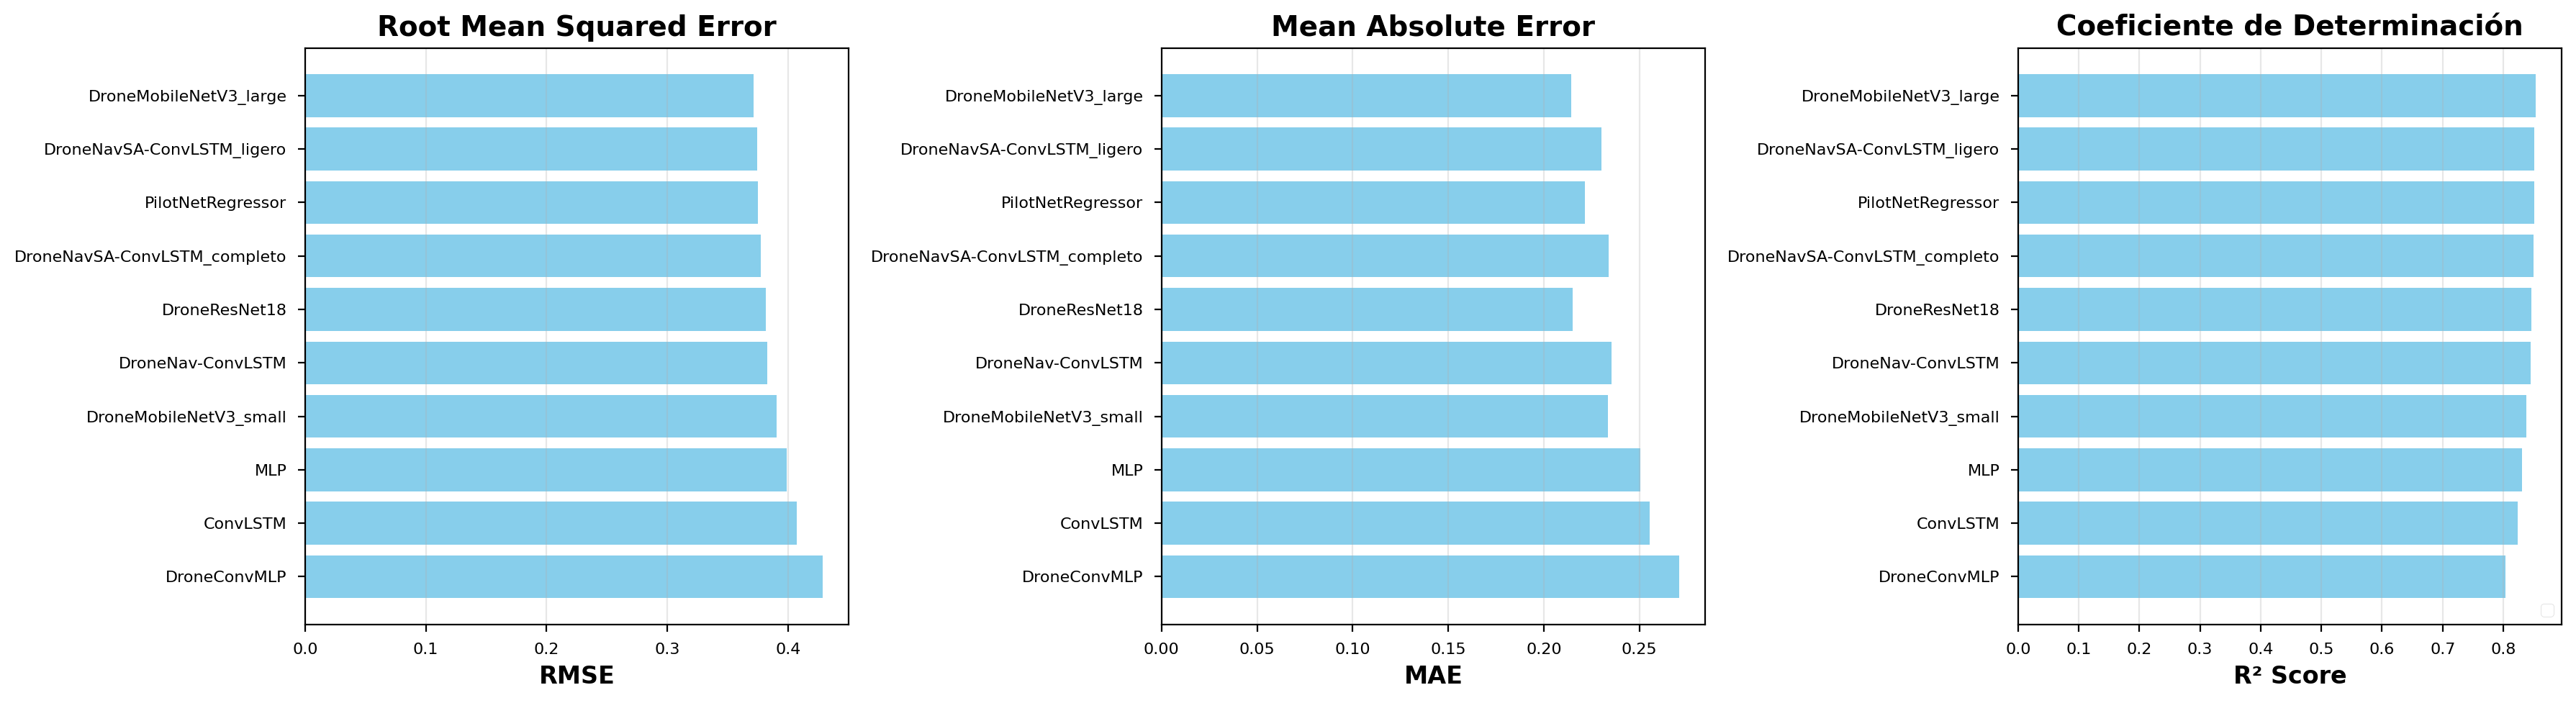

✅ Gráfica guardada: metrics_comparison.png


In [32]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Colores: azul para single-step, naranja para multi-step
colors = ['orange' if row['Multi-Step'] == '✓' else 'skyblue' for _, row in df_metrics.iterrows()]

# RMSE
axes[0].barh(df_metrics['Modelo'], df_metrics['RMSE'], color=colors)
axes[0].set_xlabel('RMSE', fontsize=12, fontweight='bold')
axes[0].set_title('Root Mean Squared Error', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# MAE
axes[1].barh(df_metrics['Modelo'], df_metrics['MAE'], color=colors)
axes[1].set_xlabel('MAE', fontsize=12, fontweight='bold')
axes[1].set_title('Mean Absolute Error', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

# R²
axes[2].barh(df_metrics['Modelo'], df_metrics['R²'], color=colors)
axes[2].set_xlabel('R² Score', fontsize=12, fontweight='bold')
axes[2].set_title('Coeficiente de Determinación', fontsize=14, fontweight='bold')
axes[2].invert_yaxis()
axes[2].grid(axis='x', alpha=0.3)

# Leyenda
from matplotlib.patches import Patch
legend_elements = [
    #Patch(facecolor='skyblue', label='Single-step'),
    #Patch(facecolor='orange', label='Multi-step')
]
axes[2].legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig('metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráfica guardada: metrics_comparison.png")

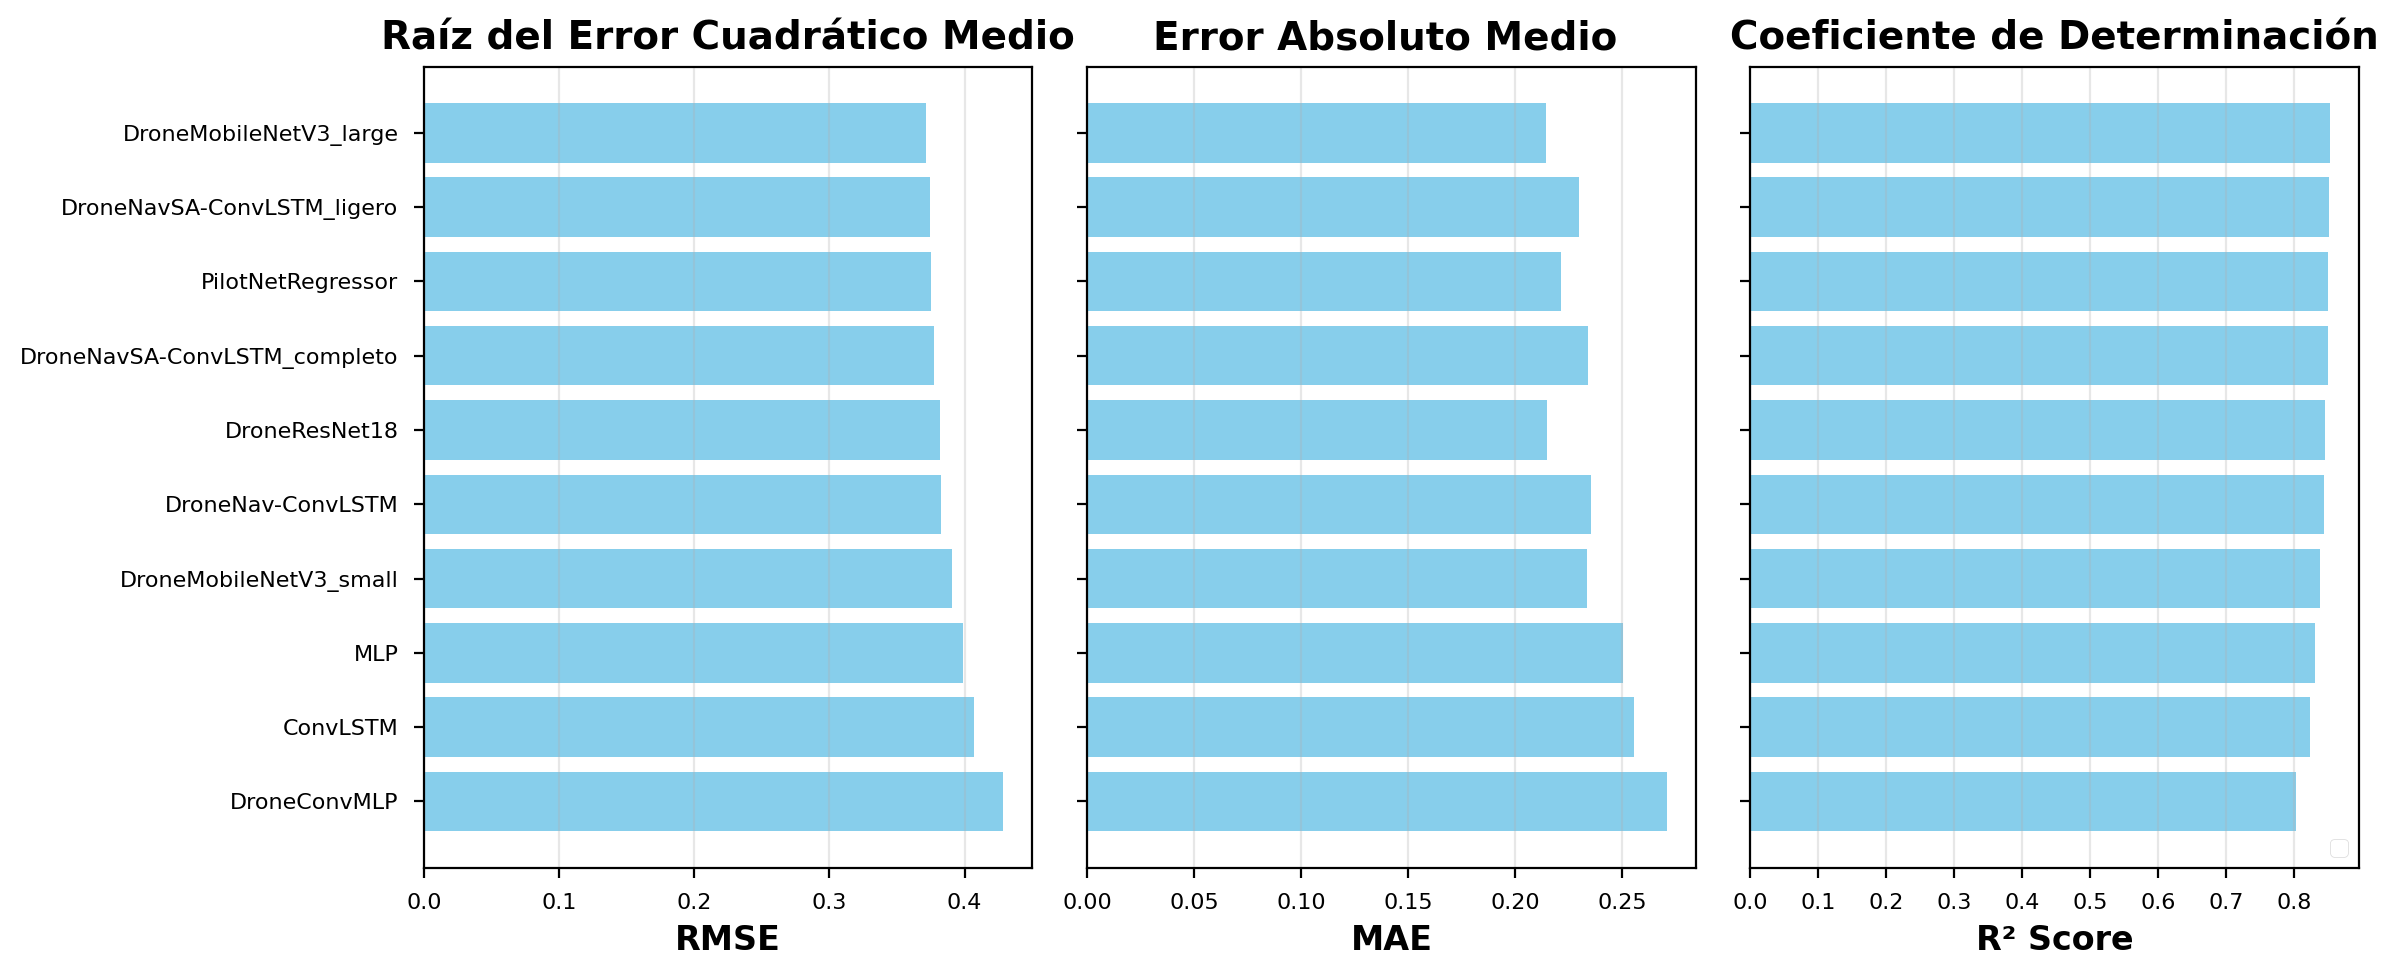

✅ Gráfica guardada: metrics_comparison.png


In [33]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

# Colores: azul para single-step, naranja para multi-step
colors = ['orange' if row['Multi-Step'] == '✓' else 'skyblue' for _, row in df_metrics.iterrows()]

# RMSE (con etiquetas de modelos)
axes[0].barh(df_metrics['Modelo'], df_metrics['RMSE'], color=colors)
axes[0].set_xlabel('RMSE', fontsize=12, fontweight='bold')
axes[0].set_title('Raíz del Error Cuadrático Medio', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# MAE (sin etiquetas de modelos)
axes[1].barh(df_metrics['Modelo'], df_metrics['MAE'], color=colors)
axes[1].set_xlabel('MAE', fontsize=12, fontweight='bold')
axes[1].set_title('Error Absoluto Medio ', fontsize=14, fontweight='bold')
axes[1].set_yticklabels([])  # Ocultar etiquetas del eje Y
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

# R² (sin etiquetas de modelos)
axes[2].barh(df_metrics['Modelo'], df_metrics['R²'], color=colors)
axes[2].set_xlabel('R² Score', fontsize=12, fontweight='bold')
axes[2].set_title('Coeficiente de Determinación', fontsize=14, fontweight='bold')
axes[2].set_yticklabels([])  # Ocultar etiquetas del eje Y
axes[2].invert_yaxis()
axes[2].grid(axis='x', alpha=0.3)

# Leyenda
from matplotlib.patches import Patch
legend_elements = [
    #Patch(facecolor='skyblue', label='Single-step'),
    #Patch(facecolor='orange', label='Multi-step')
]
axes[2].legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig('metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráfica guardada: metrics_comparison.png")

## 📊 12. Métricas por Dimensión (Todos los Modelos)

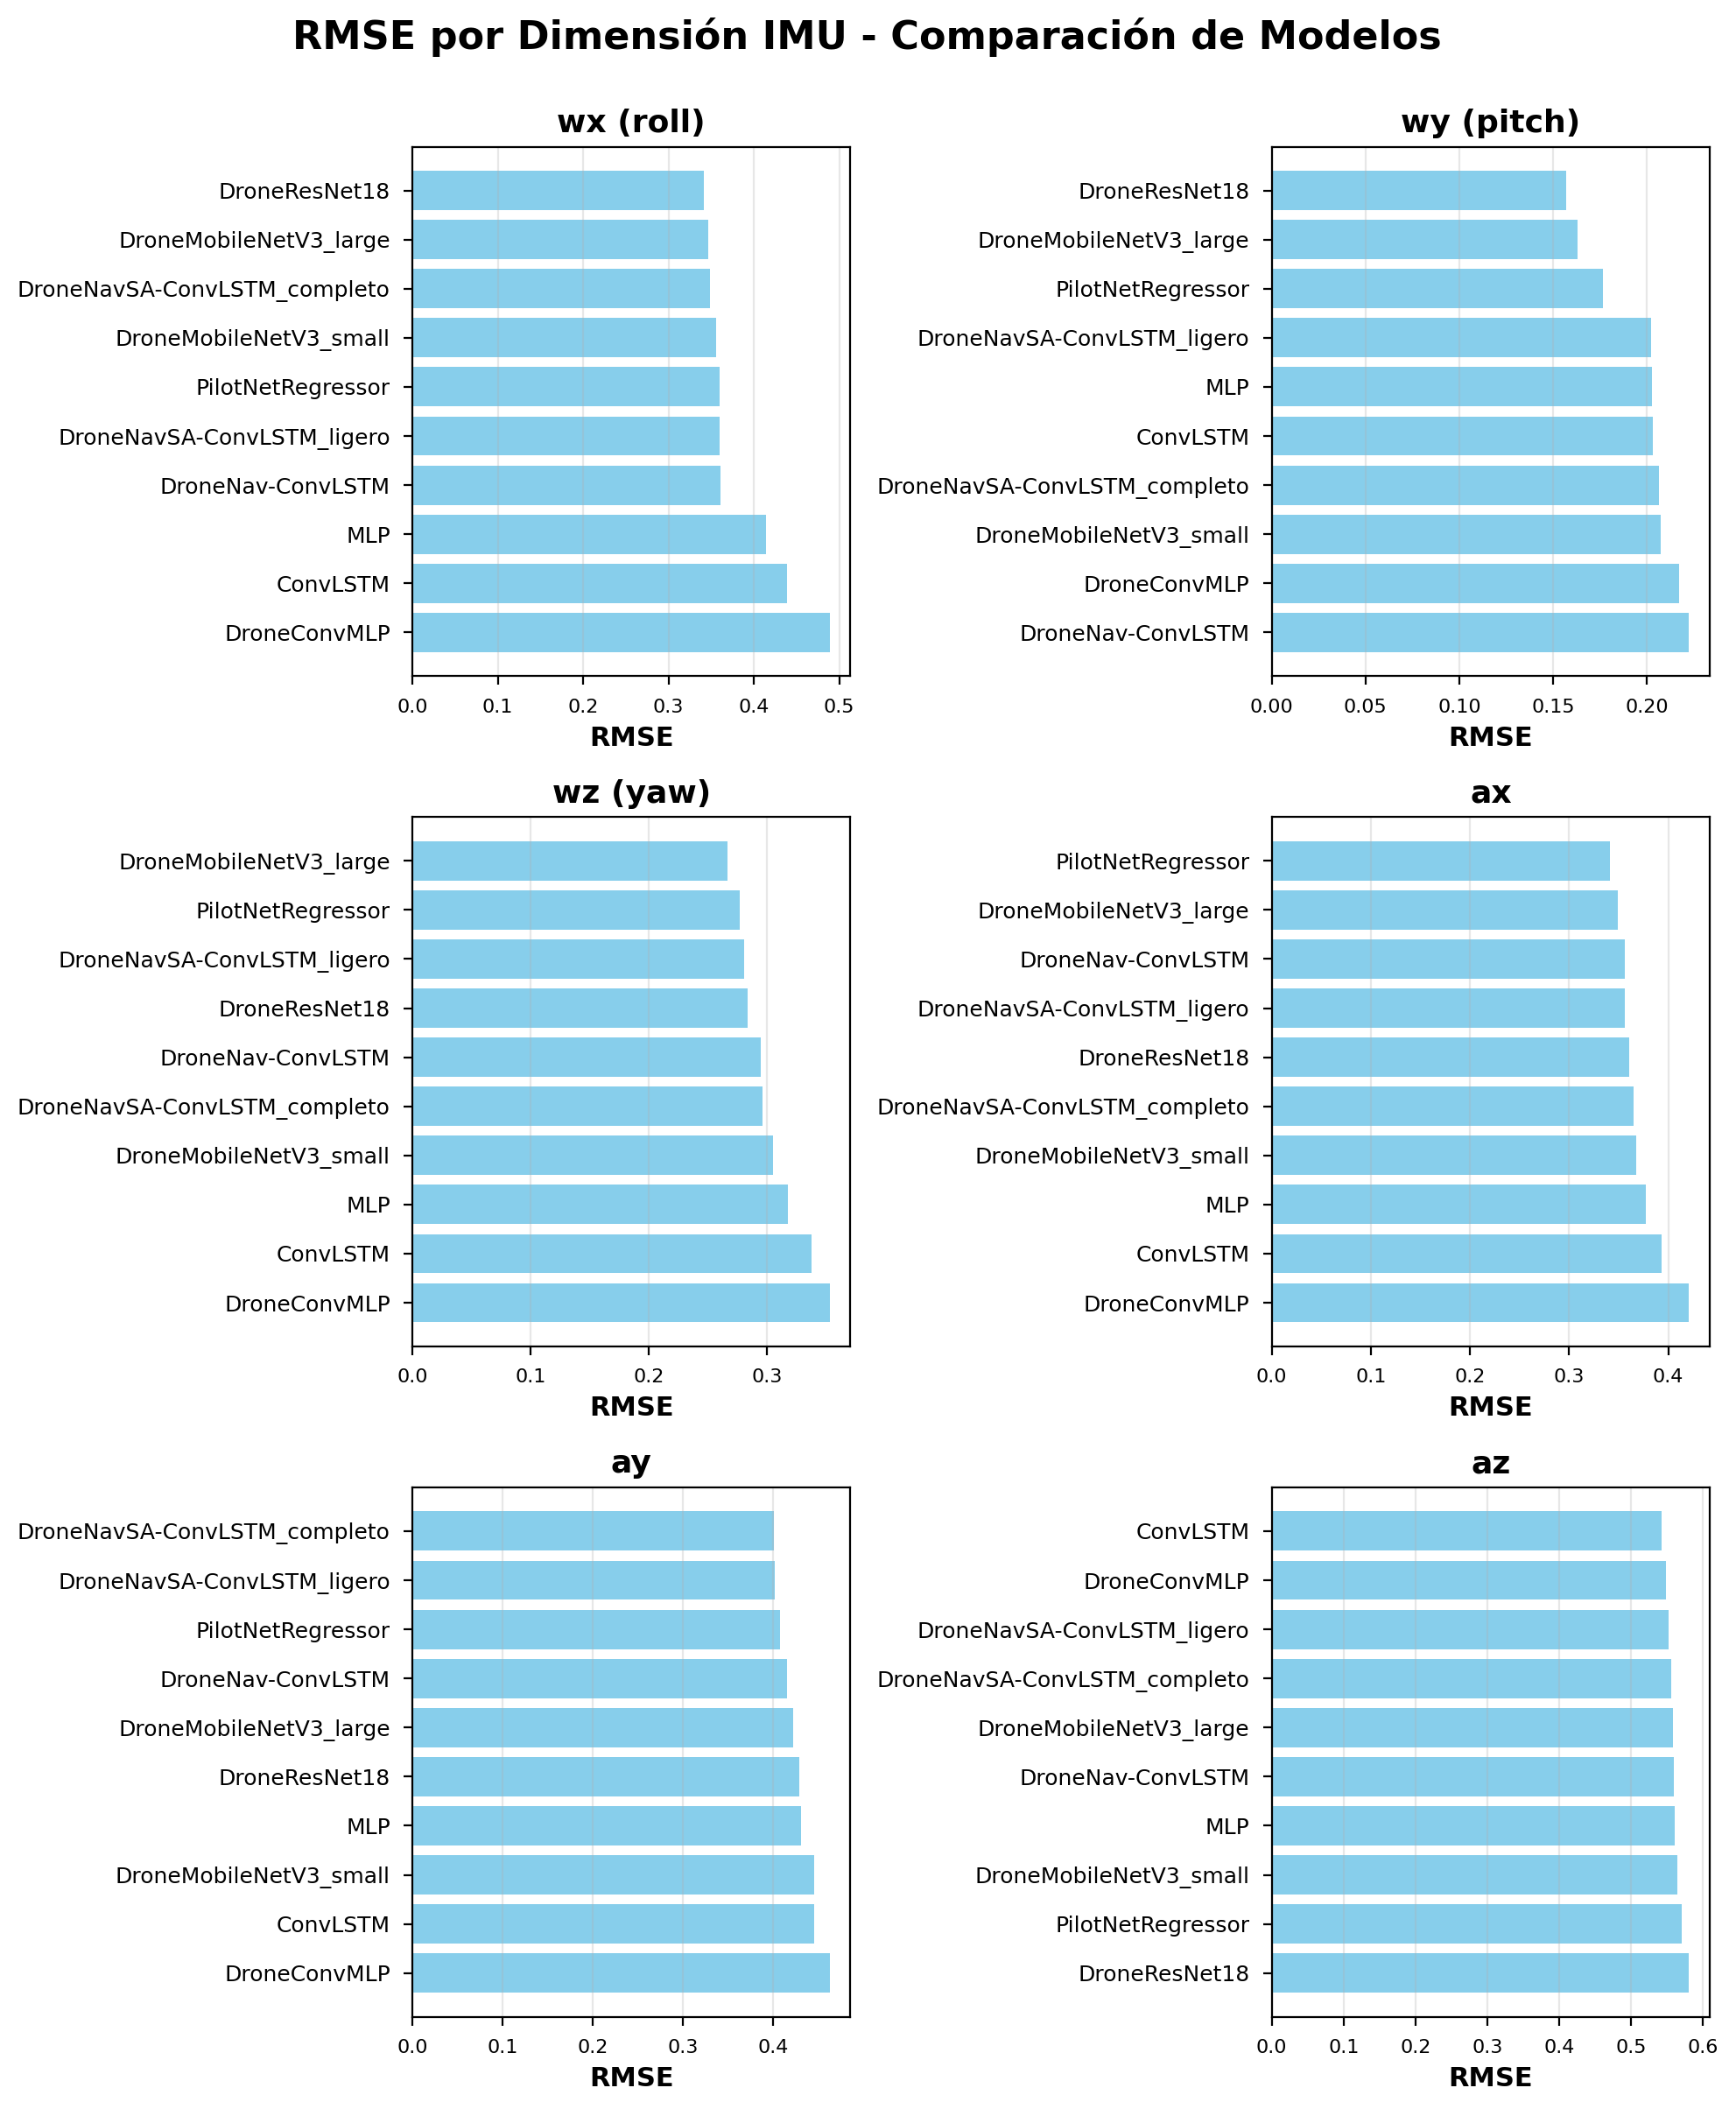

✅ Gráfica guardada: rmse_per_dimension.png


In [34]:
# Crear DataFrame con métricas por dimensión
dim_metrics_data = []

for model_name, results in all_results.items():
    for dim_name, dim_metrics in results['metrics']['per_dimension'].items():
        dim_metrics_data.append({
            'Modelo': model_name,
            'Dimensión': dim_name,
            'RMSE': dim_metrics['RMSE'],
            'MAE': dim_metrics['MAE'],
            'R²': dim_metrics['R2']
        })

df_dim_metrics = pd.DataFrame(dim_metrics_data)

# Visualizar
fig, axes = plt.subplots(3, 2, figsize=(10, 12))
axes = axes.flatten()

for i, dim_name in enumerate(IMU_NAMES):
    dim_data = df_dim_metrics[df_dim_metrics['Dimensión'] == dim_name].sort_values('RMSE')
    
    axes[i].barh(dim_data['Modelo'], dim_data['RMSE'], color='skyblue')
    axes[i].set_xlabel('RMSE', fontsize=11, fontweight='bold')
    axes[i].set_title(f'{dim_name}', fontsize=13, fontweight='bold')
    axes[i].invert_yaxis()
    axes[i].grid(axis='x', alpha=0.3)
    axes[i].tick_params(axis='y', labelsize=9)

plt.suptitle('RMSE por Dimensión IMU - Comparación de Modelos', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('rmse_per_dimension.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráfica guardada: rmse_per_dimension.png")

## 🎯 13. Scatter Plots: Predicciones vs Ground Truth

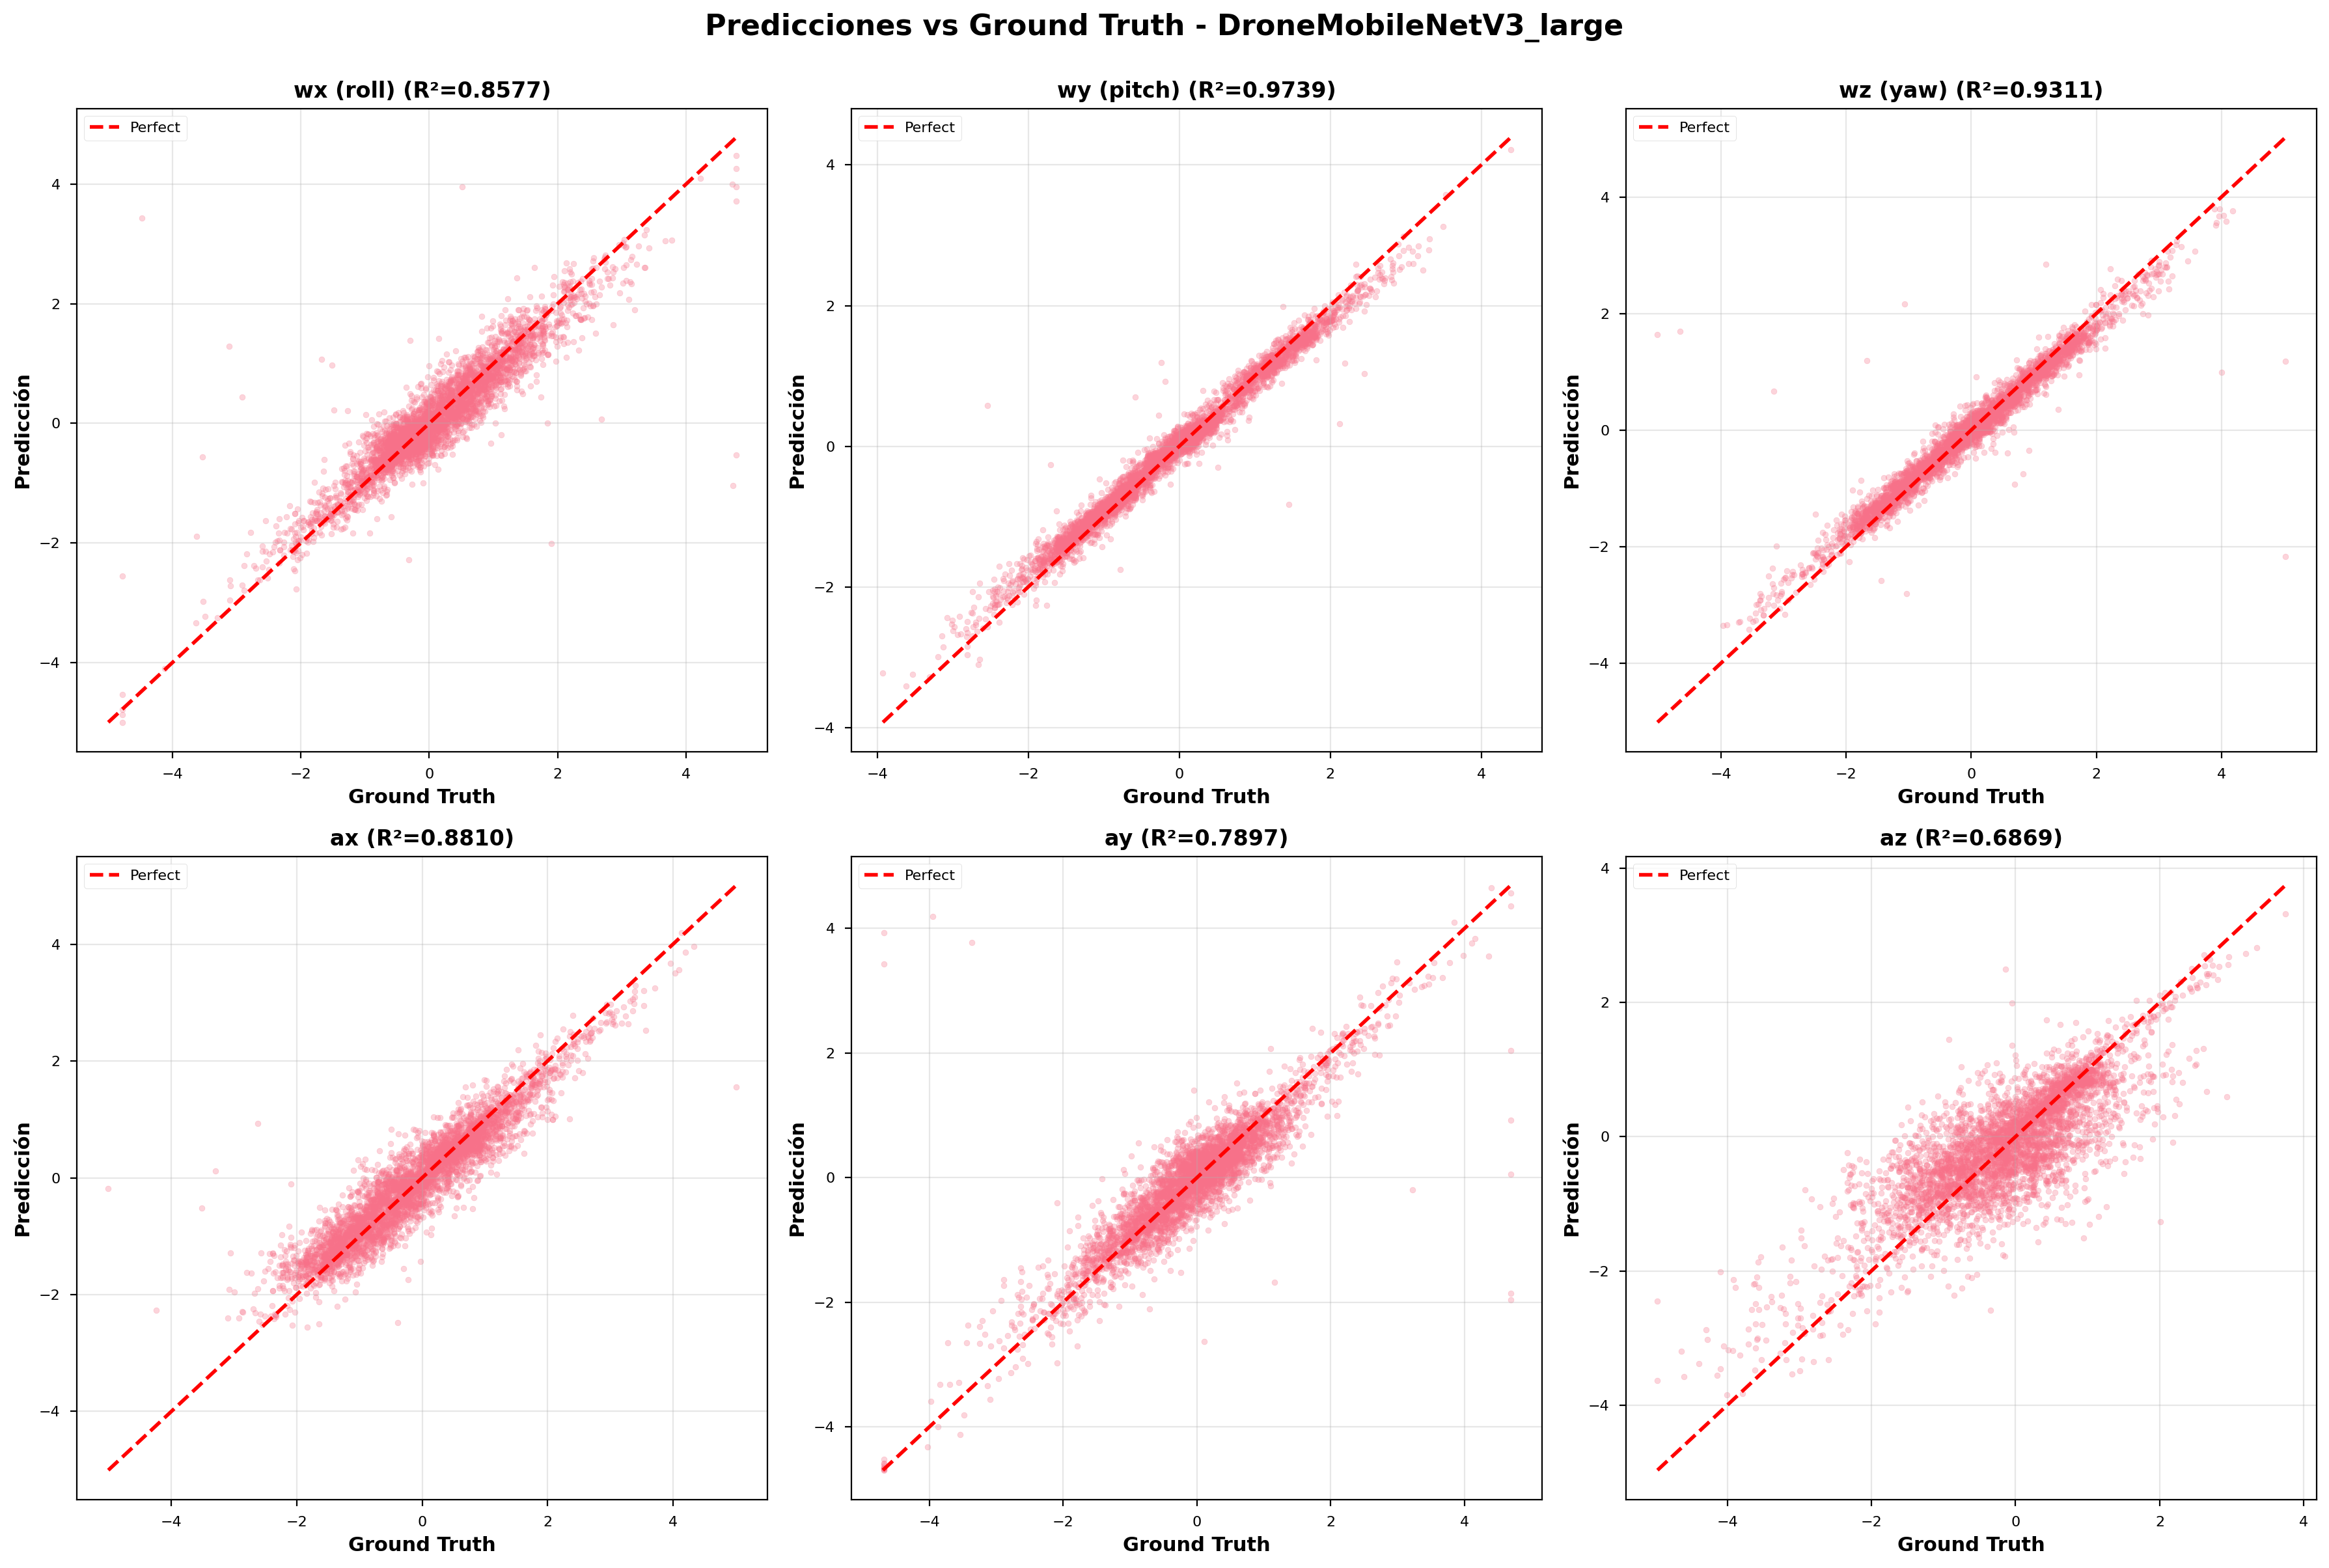

✅ Gráfica guardada: scatter_DroneMobileNetV3_large.png


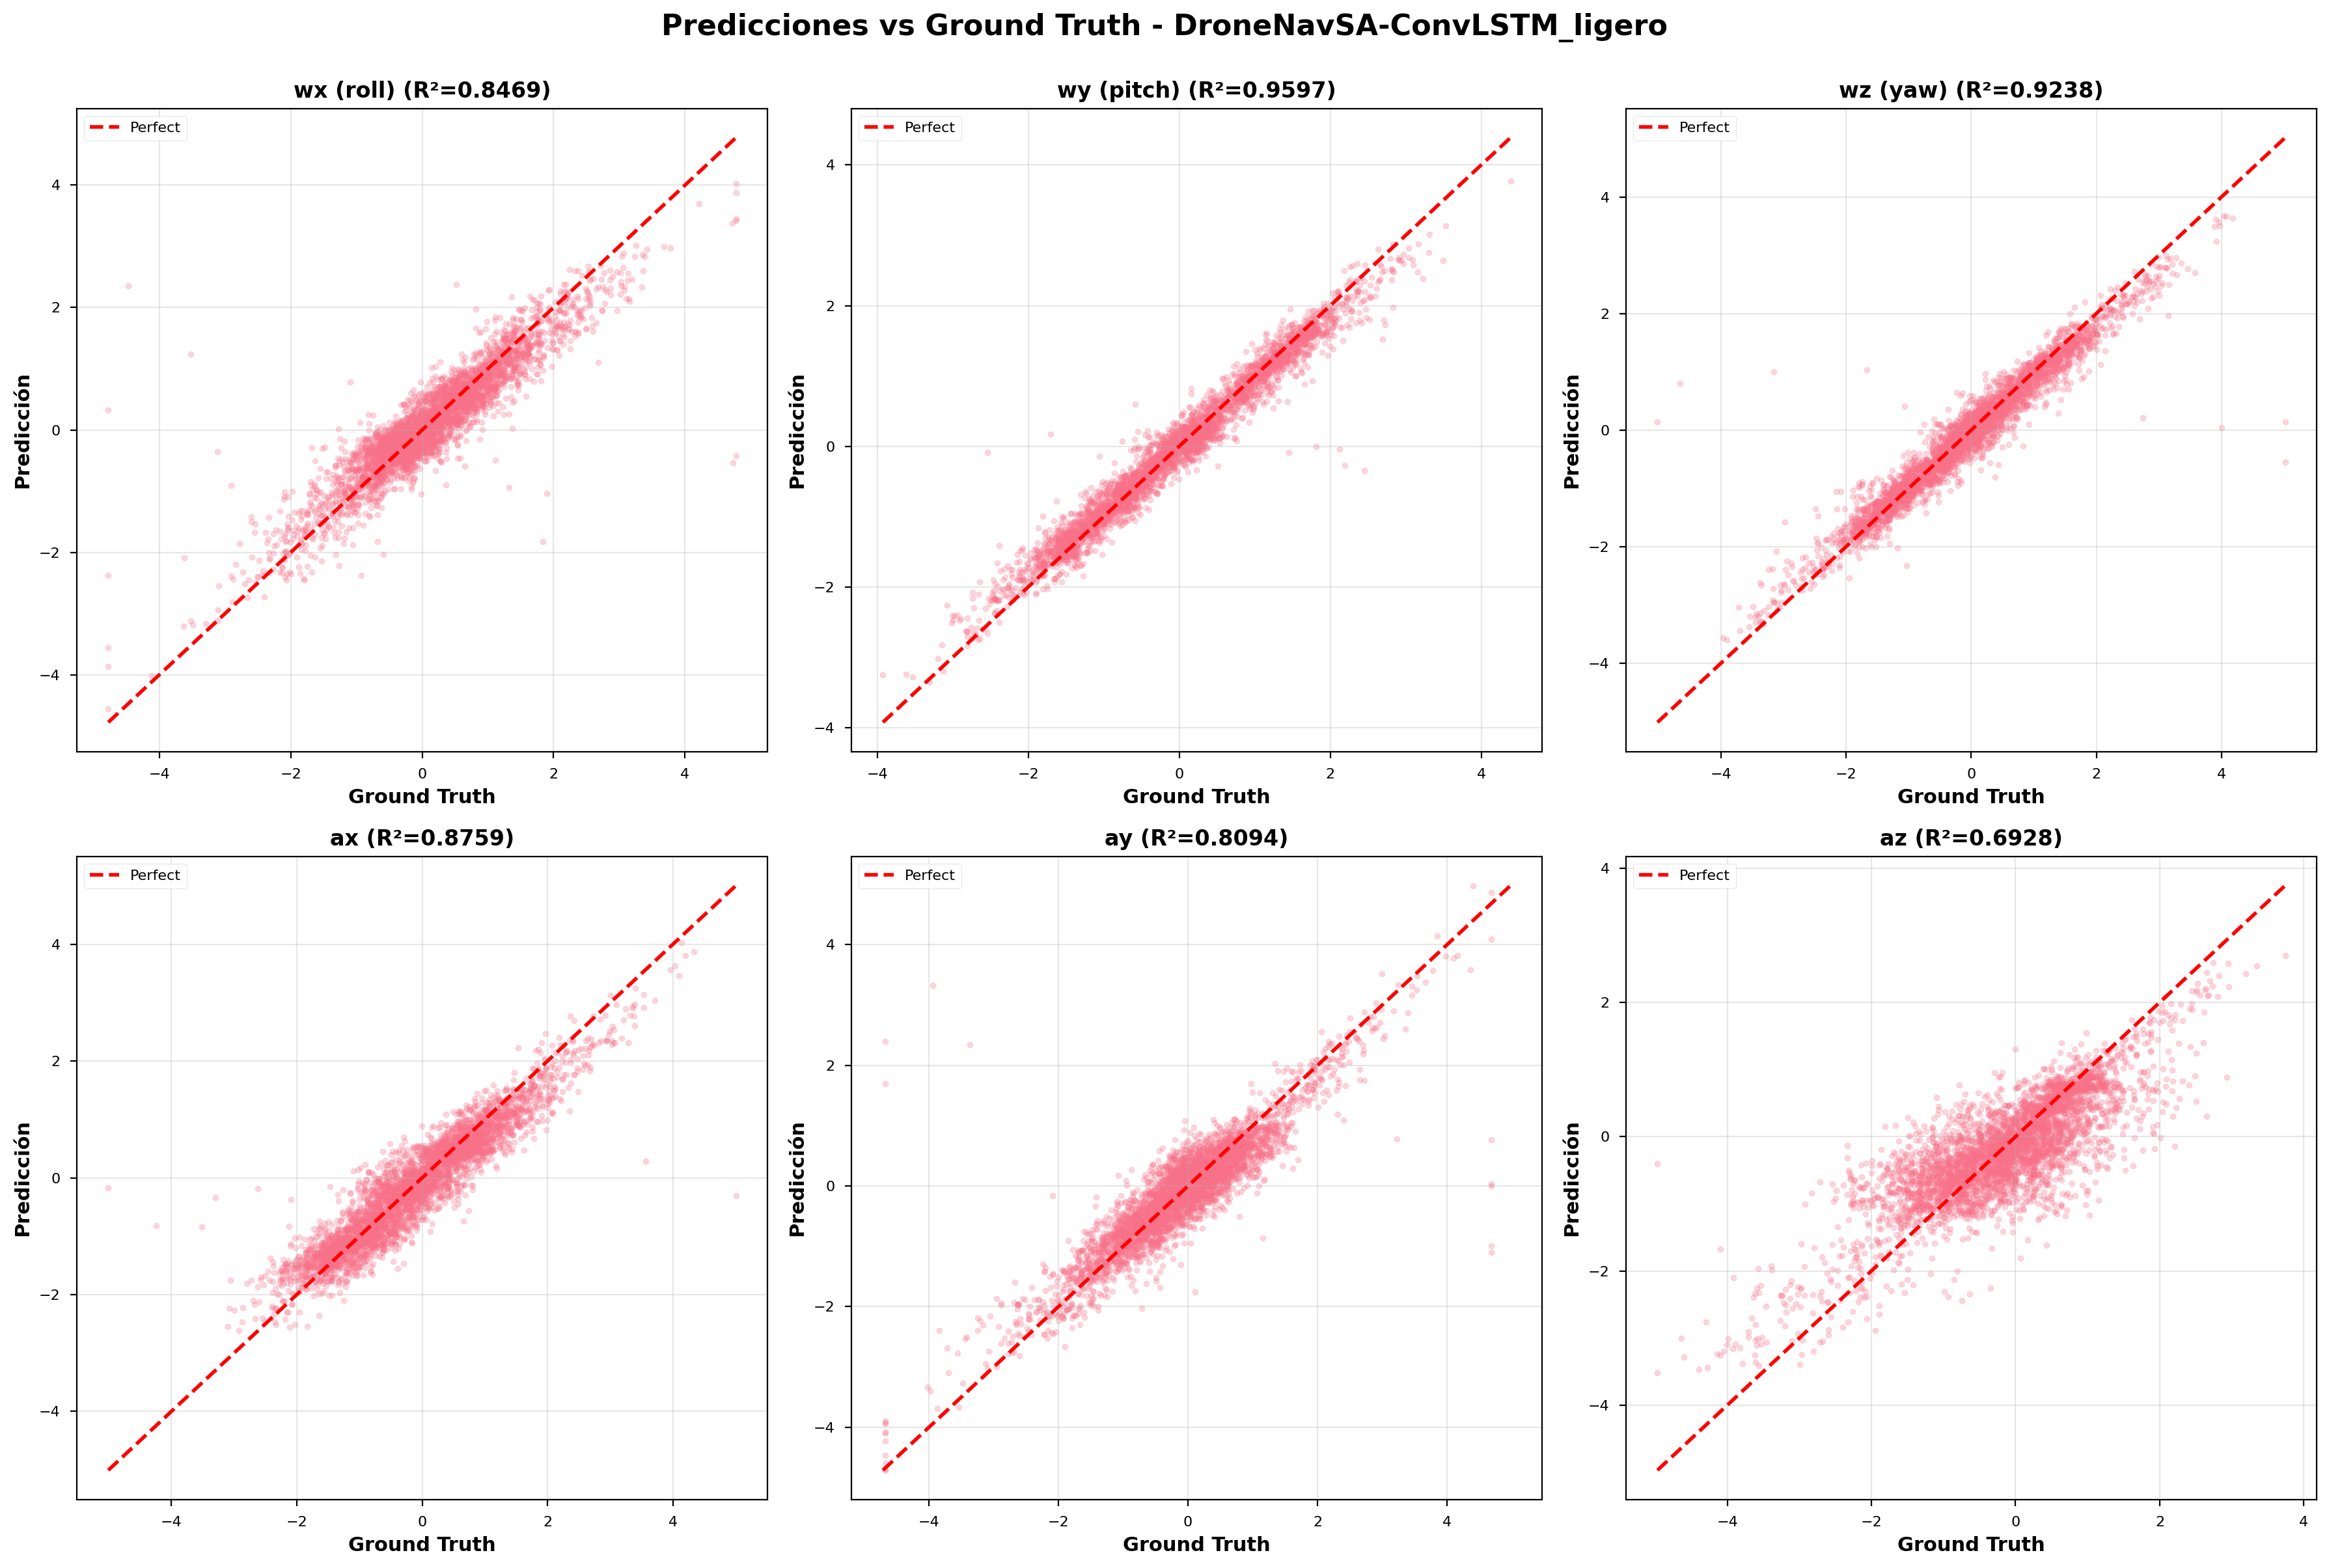

✅ Gráfica guardada: scatter_DroneNavSA-ConvLSTM_ligero.png


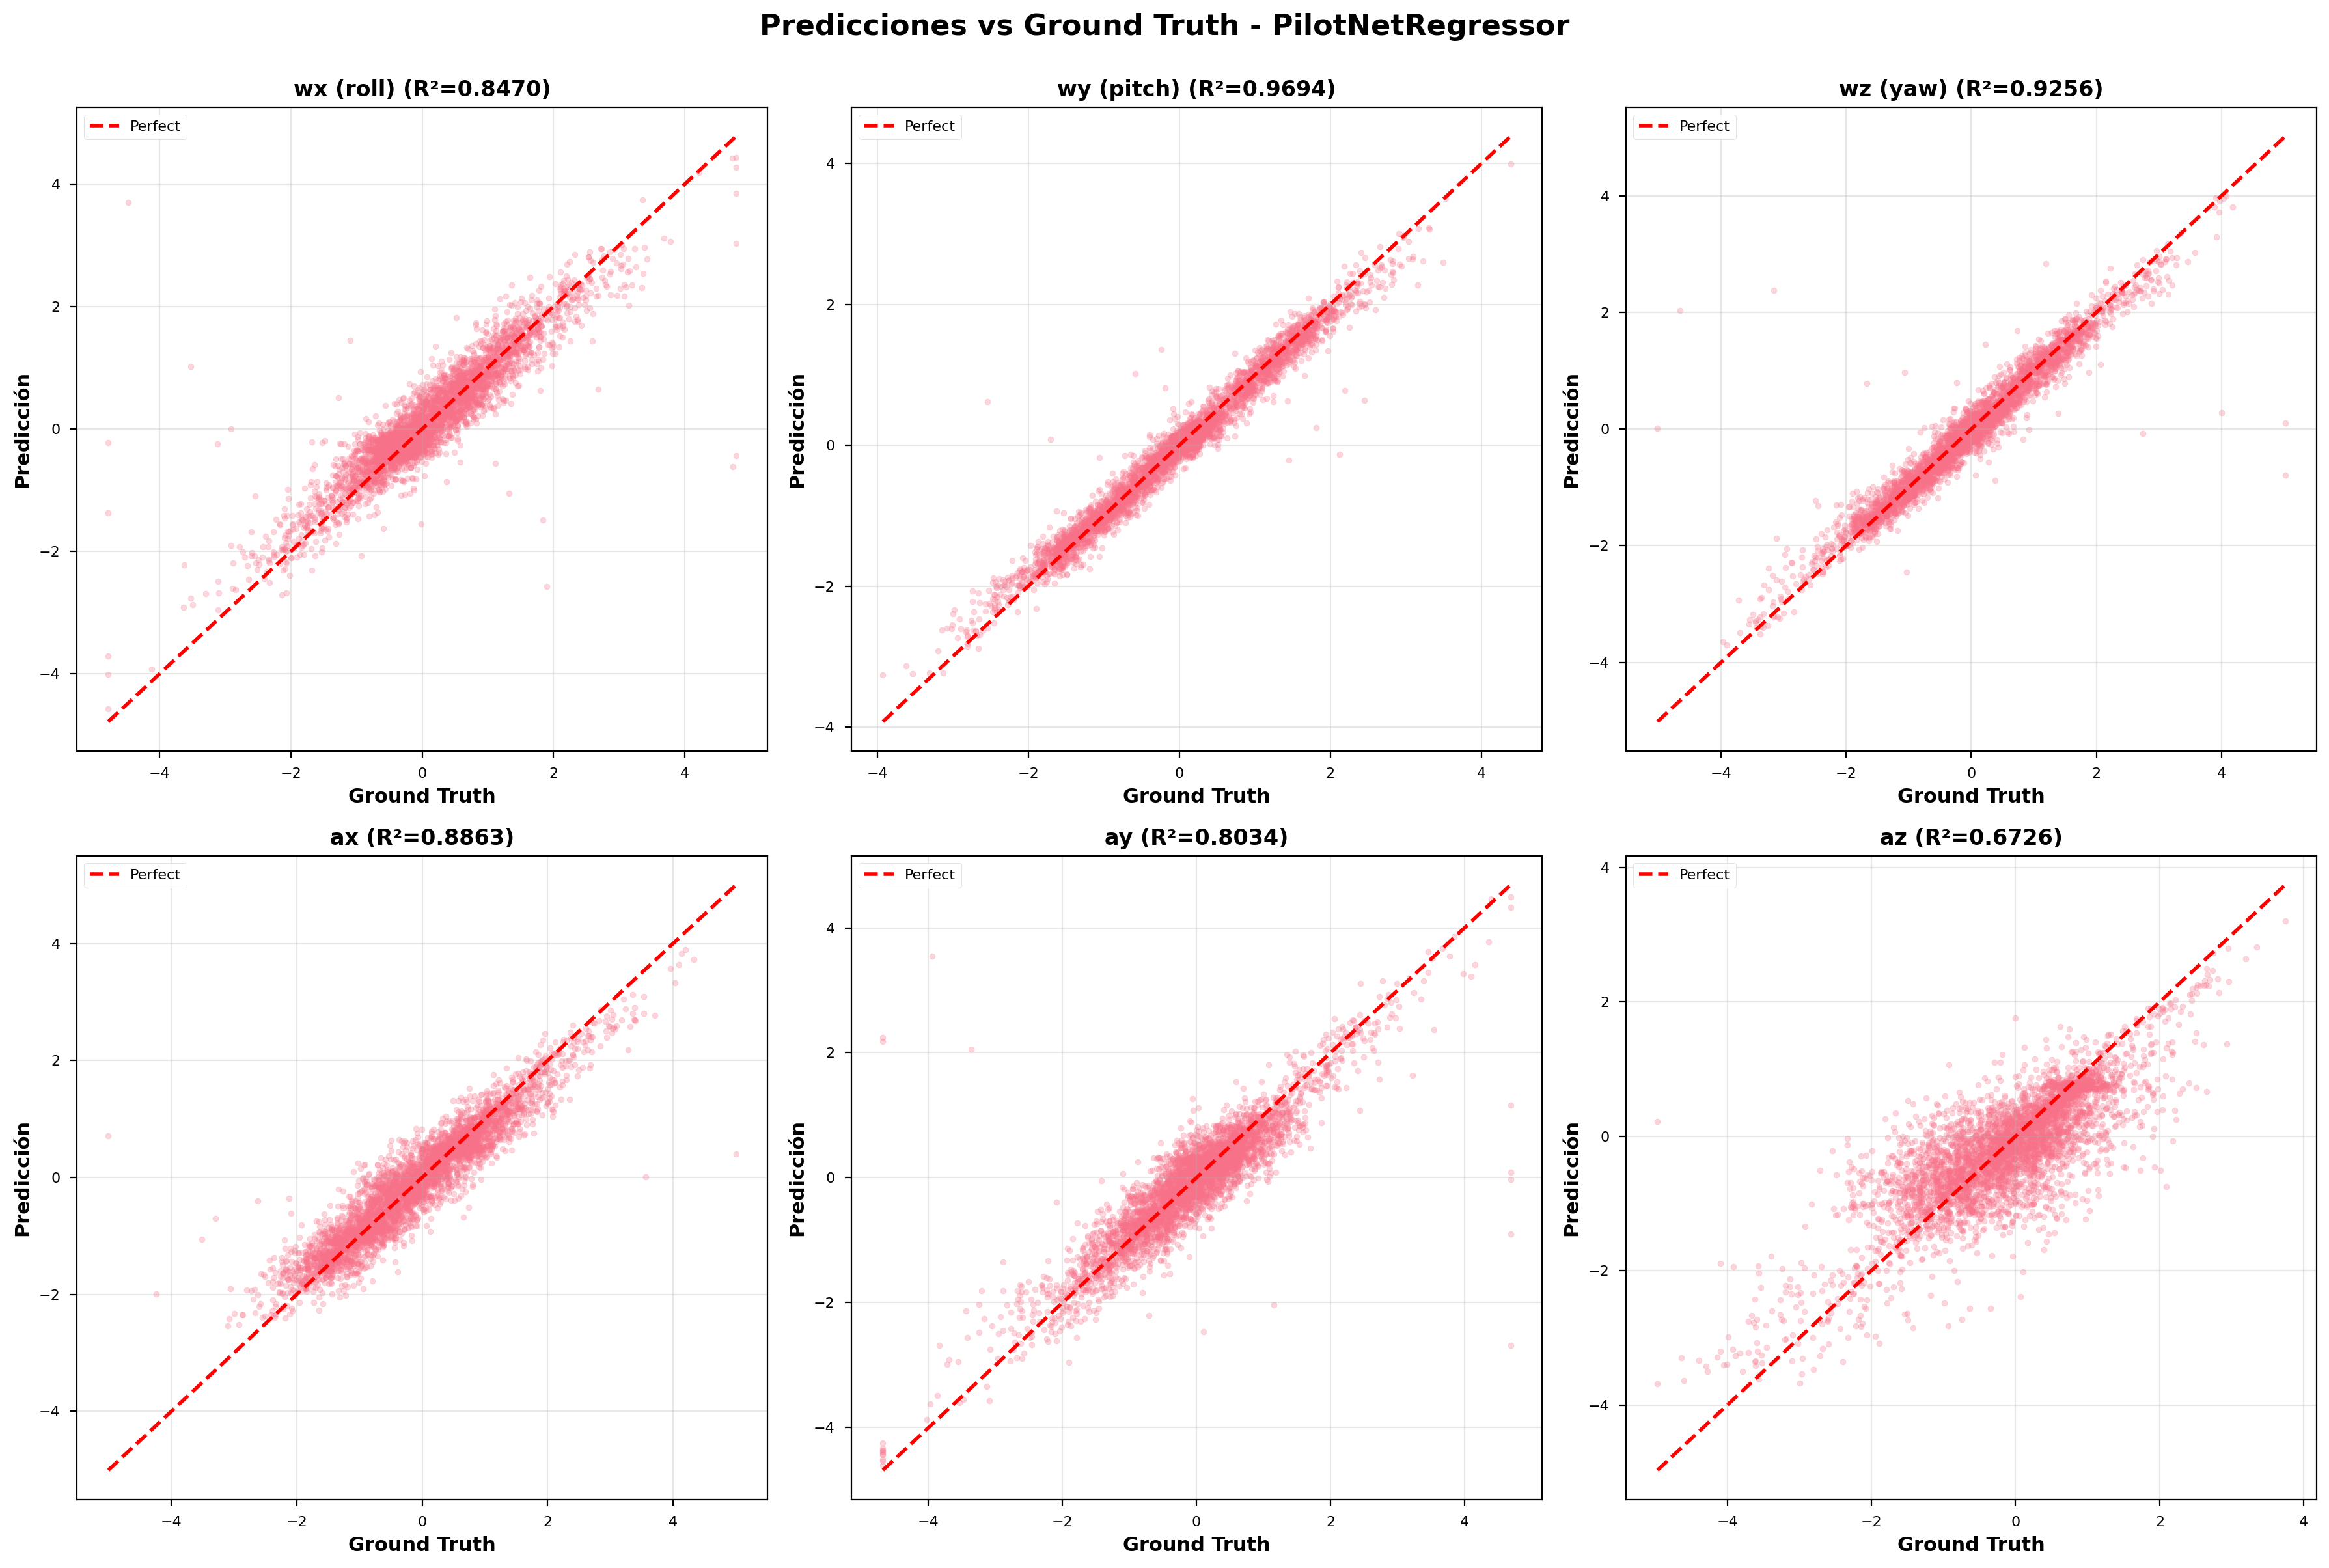

✅ Gráfica guardada: scatter_PilotNetRegressor.png


In [35]:
# Seleccionar top 3 modelos para visualizar
top_3_models = df_metrics.head(3)['Modelo'].tolist()

for model_name in top_3_models:
    y_true = all_results[model_name]['y_true']
    y_pred = all_results[model_name]['y_pred']
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, dim_name in enumerate(IMU_NAMES):
        # Scatter plot
        axes[i].scatter(y_true[:, i], y_pred[:, i], alpha=0.3, s=10)
        
        # Línea perfecta (y=x)
        min_val = min(y_true[:, i].min(), y_pred[:, i].min())
        max_val = max(y_true[:, i].max(), y_pred[:, i].max())
        axes[i].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect')
        
        # Calcular R²
        r2 = r2_score(y_true[:, i], y_pred[:, i])
        
        axes[i].set_xlabel('Ground Truth', fontsize=11, fontweight='bold')
        axes[i].set_ylabel('Predicción', fontsize=11, fontweight='bold')
        axes[i].set_title(f'{dim_name} (R²={r2:.4f})', fontsize=12, fontweight='bold')
        axes[i].legend()
        axes[i].grid(alpha=0.3)
    
    plt.suptitle(f'Predicciones vs Ground Truth - {model_name}', 
                 fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    filename = f'scatter_{model_name.replace(" ", "_")}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Gráfica guardada: {filename}")

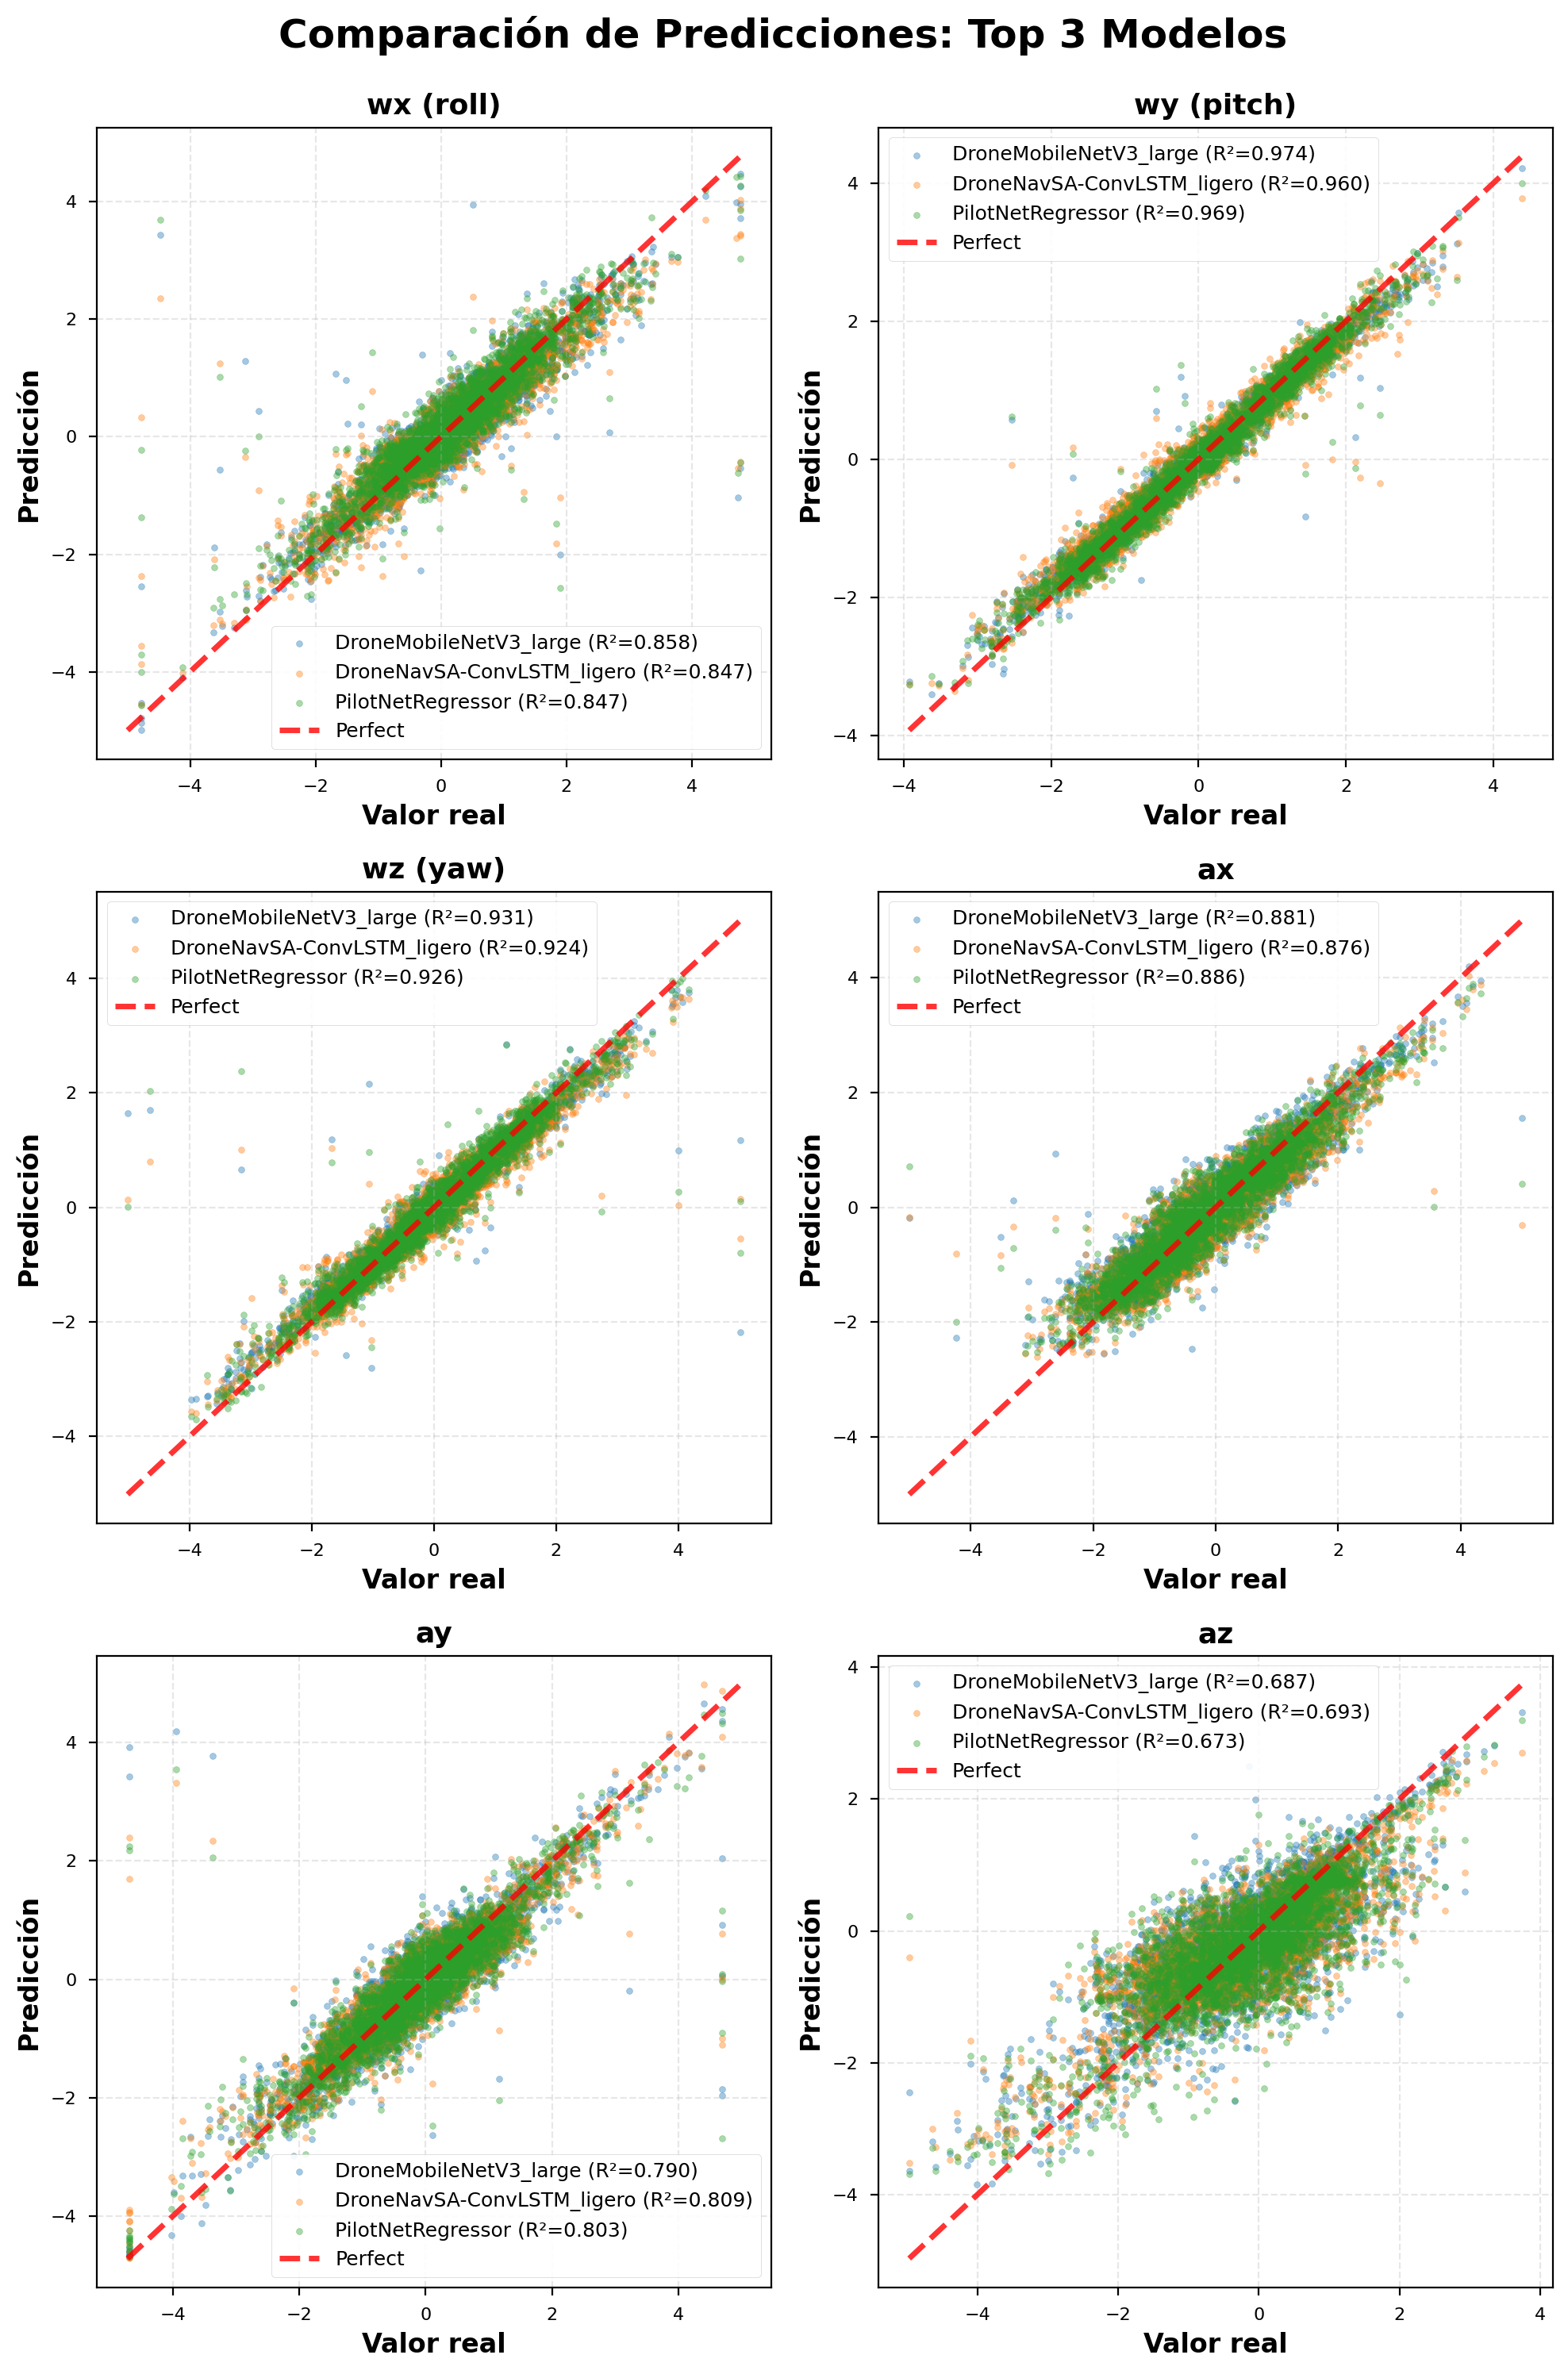

✅ Gráfica comparativa guardada: scatter_comparison_top3_models.png


In [36]:
# Seleccionar top 3 modelos para visualizar
top_3_models = df_metrics.head(3)['Modelo'].tolist()

# Colores para cada modelo
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Azul, Naranja, Verde

# Crear una sola figura con todos los modelos
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
axes = axes.flatten()

for i, dim_name in enumerate(IMU_NAMES):
    # Para cada dimensión, plotear los 3 modelos
    for idx, model_name in enumerate(top_3_models):
        y_true = all_results[model_name]['y_true']
        y_pred = all_results[model_name]['y_pred']
        
        # Calcular R² para este modelo y dimensión
        r2 = r2_score(y_true[:, i], y_pred[:, i])
        
        # Scatter plot con transparencia
        axes[i].scatter(y_true[:, i], y_pred[:, i], 
                       alpha=0.4, s=8, 
                       color=colors[idx],
                       label=f'{model_name} (R²={r2:.3f})')
    
    # Línea perfecta (y=x) - calcular rango considerando todos los modelos
    all_true = []
    all_pred = []
    for model_name in top_3_models:
        all_true.extend(all_results[model_name]['y_true'][:, i])
        all_pred.extend(all_results[model_name]['y_pred'][:, i])
    
    min_val = min(min(all_true), min(all_pred))
    max_val = max(max(all_true), max(all_pred))
    axes[i].plot([min_val, max_val], [min_val, max_val], 
                'r--', lw=2.5, label='Perfect', alpha=0.8)
    
    # Configuración del subplot
    axes[i].set_xlabel('Valor real', fontsize=12, fontweight='bold')
    axes[i].set_ylabel('Predicción', fontsize=12, fontweight='bold')
    axes[i].set_title(f'{dim_name}', fontsize=13, fontweight='bold')
    axes[i].legend(loc='best', fontsize=9, framealpha=0.9)
    axes[i].grid(alpha=0.3, linestyle='--')

plt.suptitle('Comparación de Predicciones: Top 3 Modelos', 
             fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()

# Guardar
filename = 'scatter_comparison_top3_models.png'
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Gráfica comparativa guardada: {filename}")

## 📉 14. Distribución de Errores

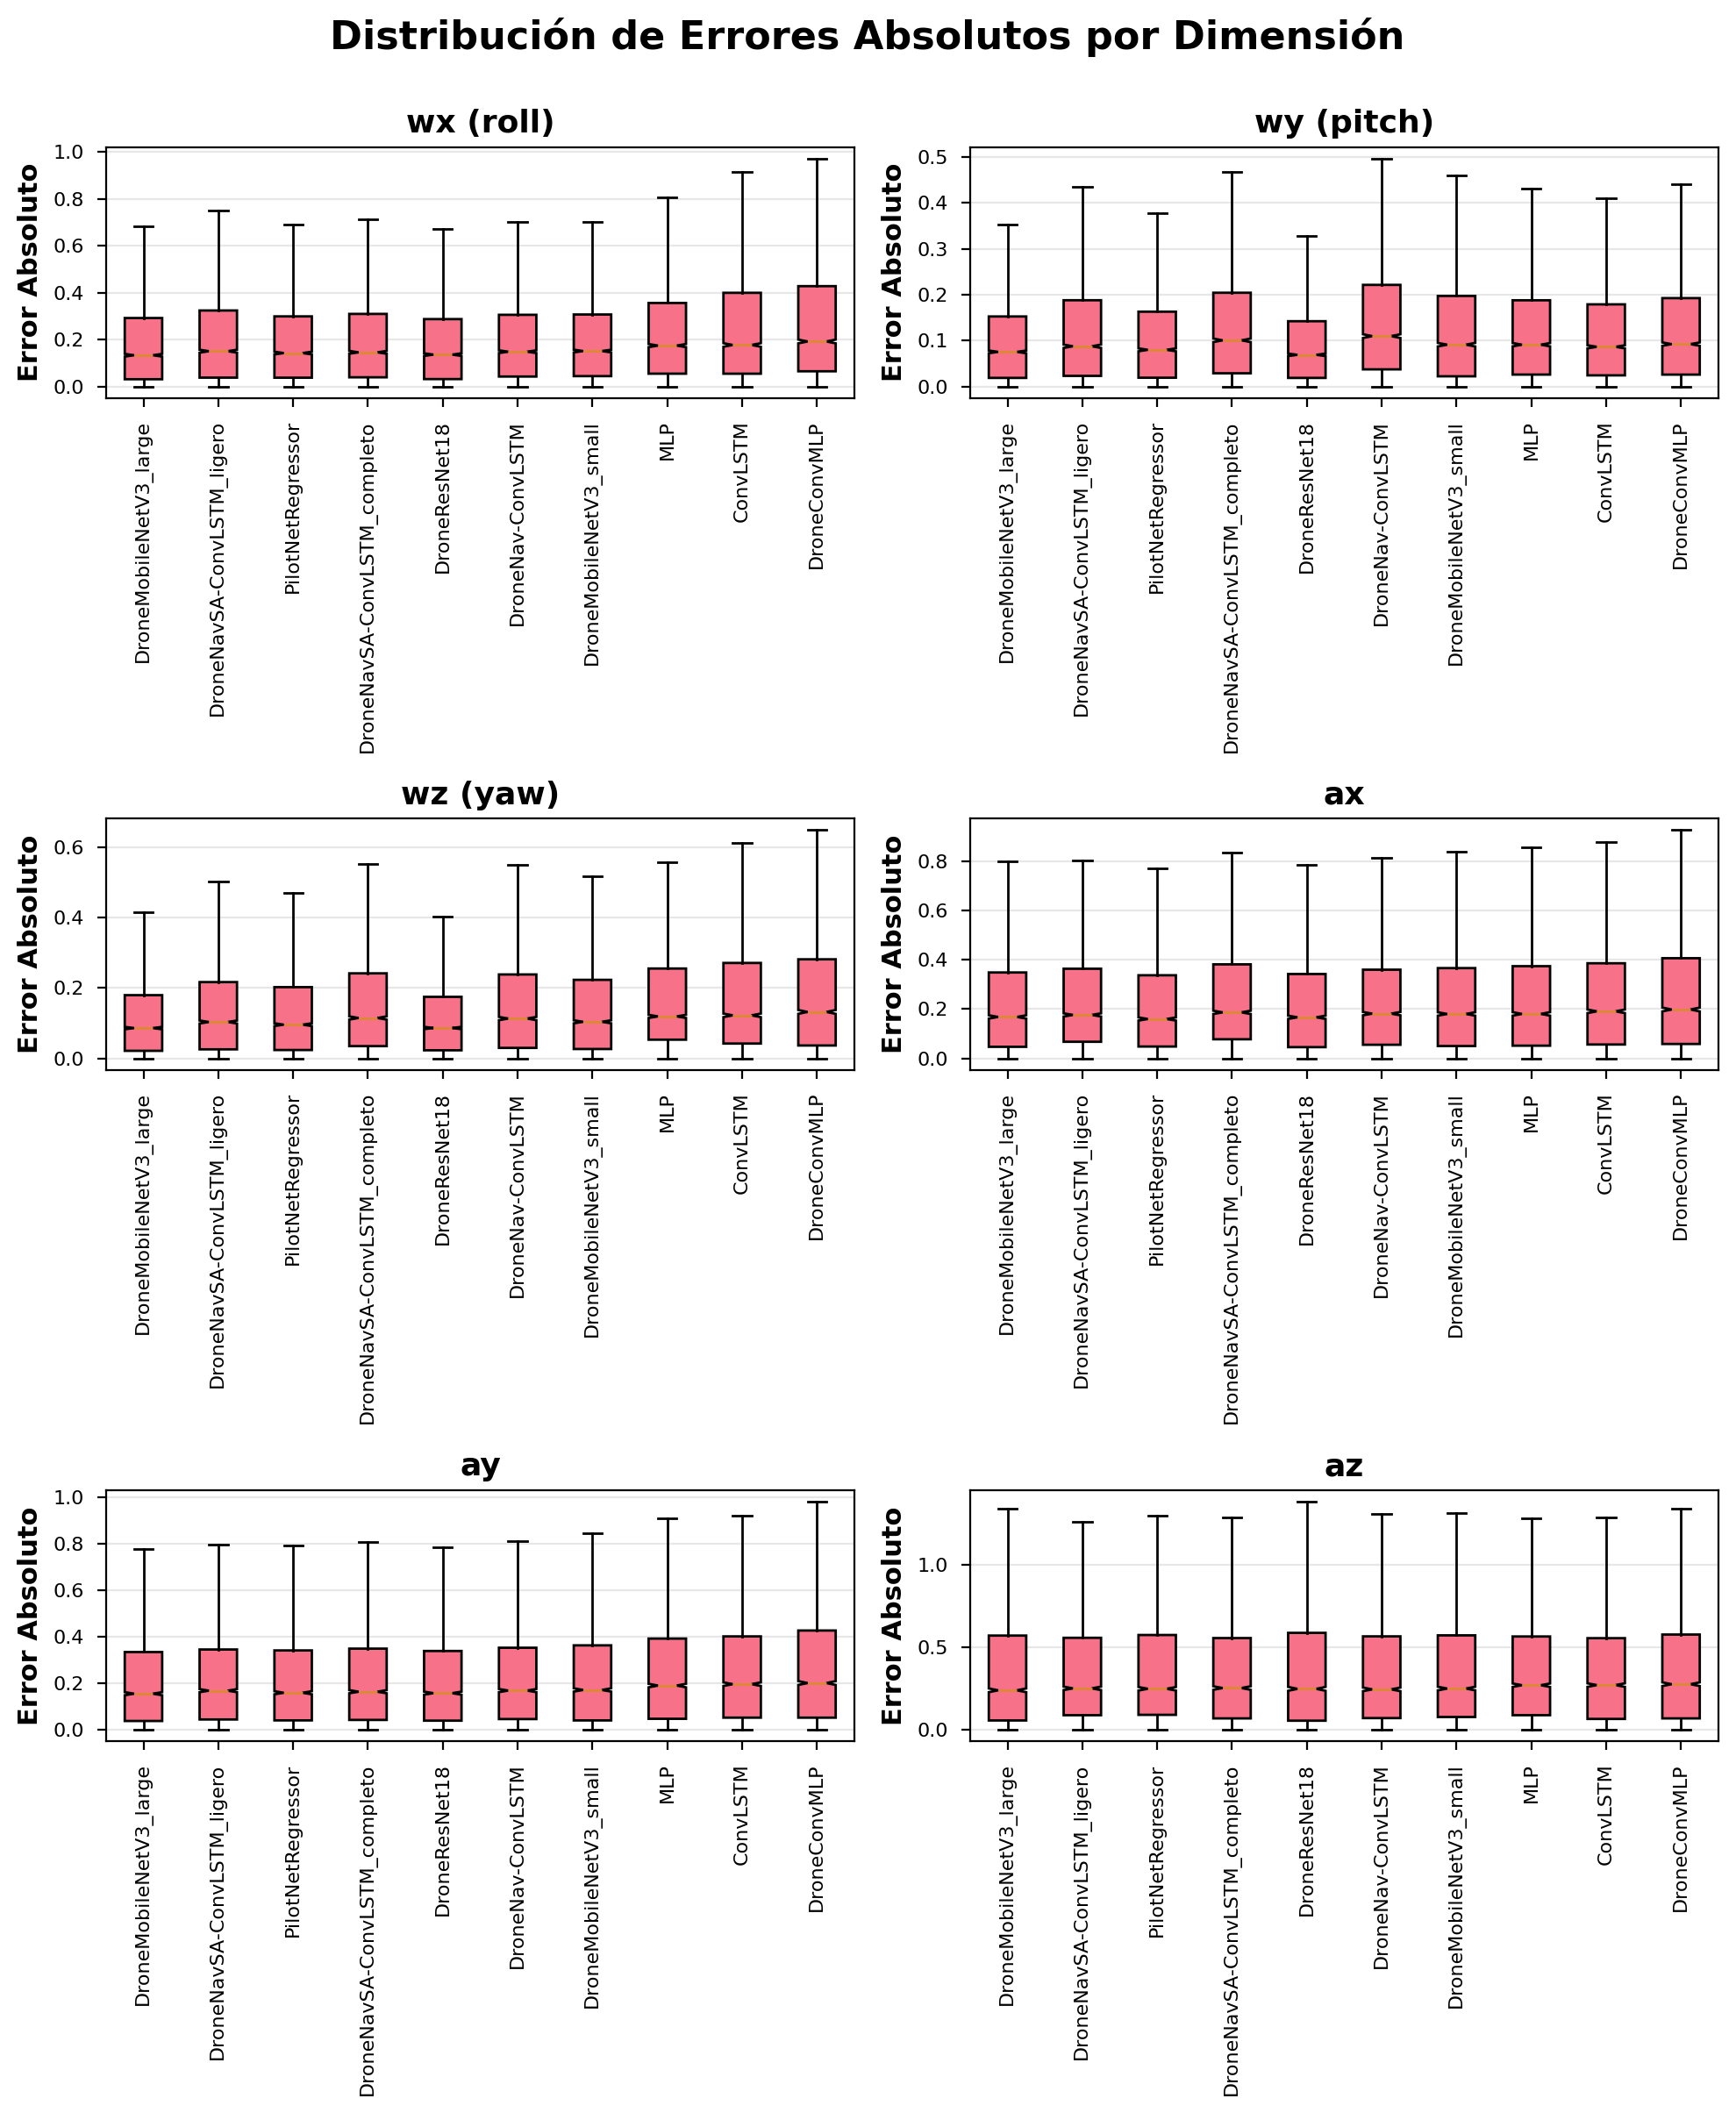

✅ Gráfica guardada: error_distribution.png


In [37]:
# Box plots de errores absolutos para todos los modelos
fig, axes = plt.subplots(3, 2, figsize=(10, 12))
axes = axes.flatten()

for i, dim_name in enumerate(IMU_NAMES):
    errors_data = []
    labels = []
    
    for model_name in df_metrics['Modelo']:
        y_true = all_results[model_name]['y_true'][:, i]
        y_pred = all_results[model_name]['y_pred'][:, i]
        errors = np.abs(y_true - y_pred)
        errors_data.append(errors)
        labels.append(model_name)
    
    bp = axes[i].boxplot(errors_data, labels=labels, patch_artist=True, 
                          showfliers=False, notch=True)
    
    # Colorear cajas
    #colors = sns.color_palette("husl", len(all_results))
    #colors = 'orange'
    #for patch, color in zip(bp['boxes'], colors):
    #    patch.set_facecolor(color)
    #    patch.set_alpha(0.7)
    
    axes[i].set_ylabel('Error Absoluto', fontsize=11, fontweight='bold')
    axes[i].set_title(f'{dim_name}', fontsize=13, fontweight='bold')
    axes[i].tick_params(axis='x', rotation=90, labelsize=8)
    axes[i].grid(axis='y', alpha=0.3)

plt.suptitle('Distribución de Errores Absolutos por Dimensión', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('error_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráfica guardada: error_distribution.png")

## 📊 15. Heatmap de Rendimiento

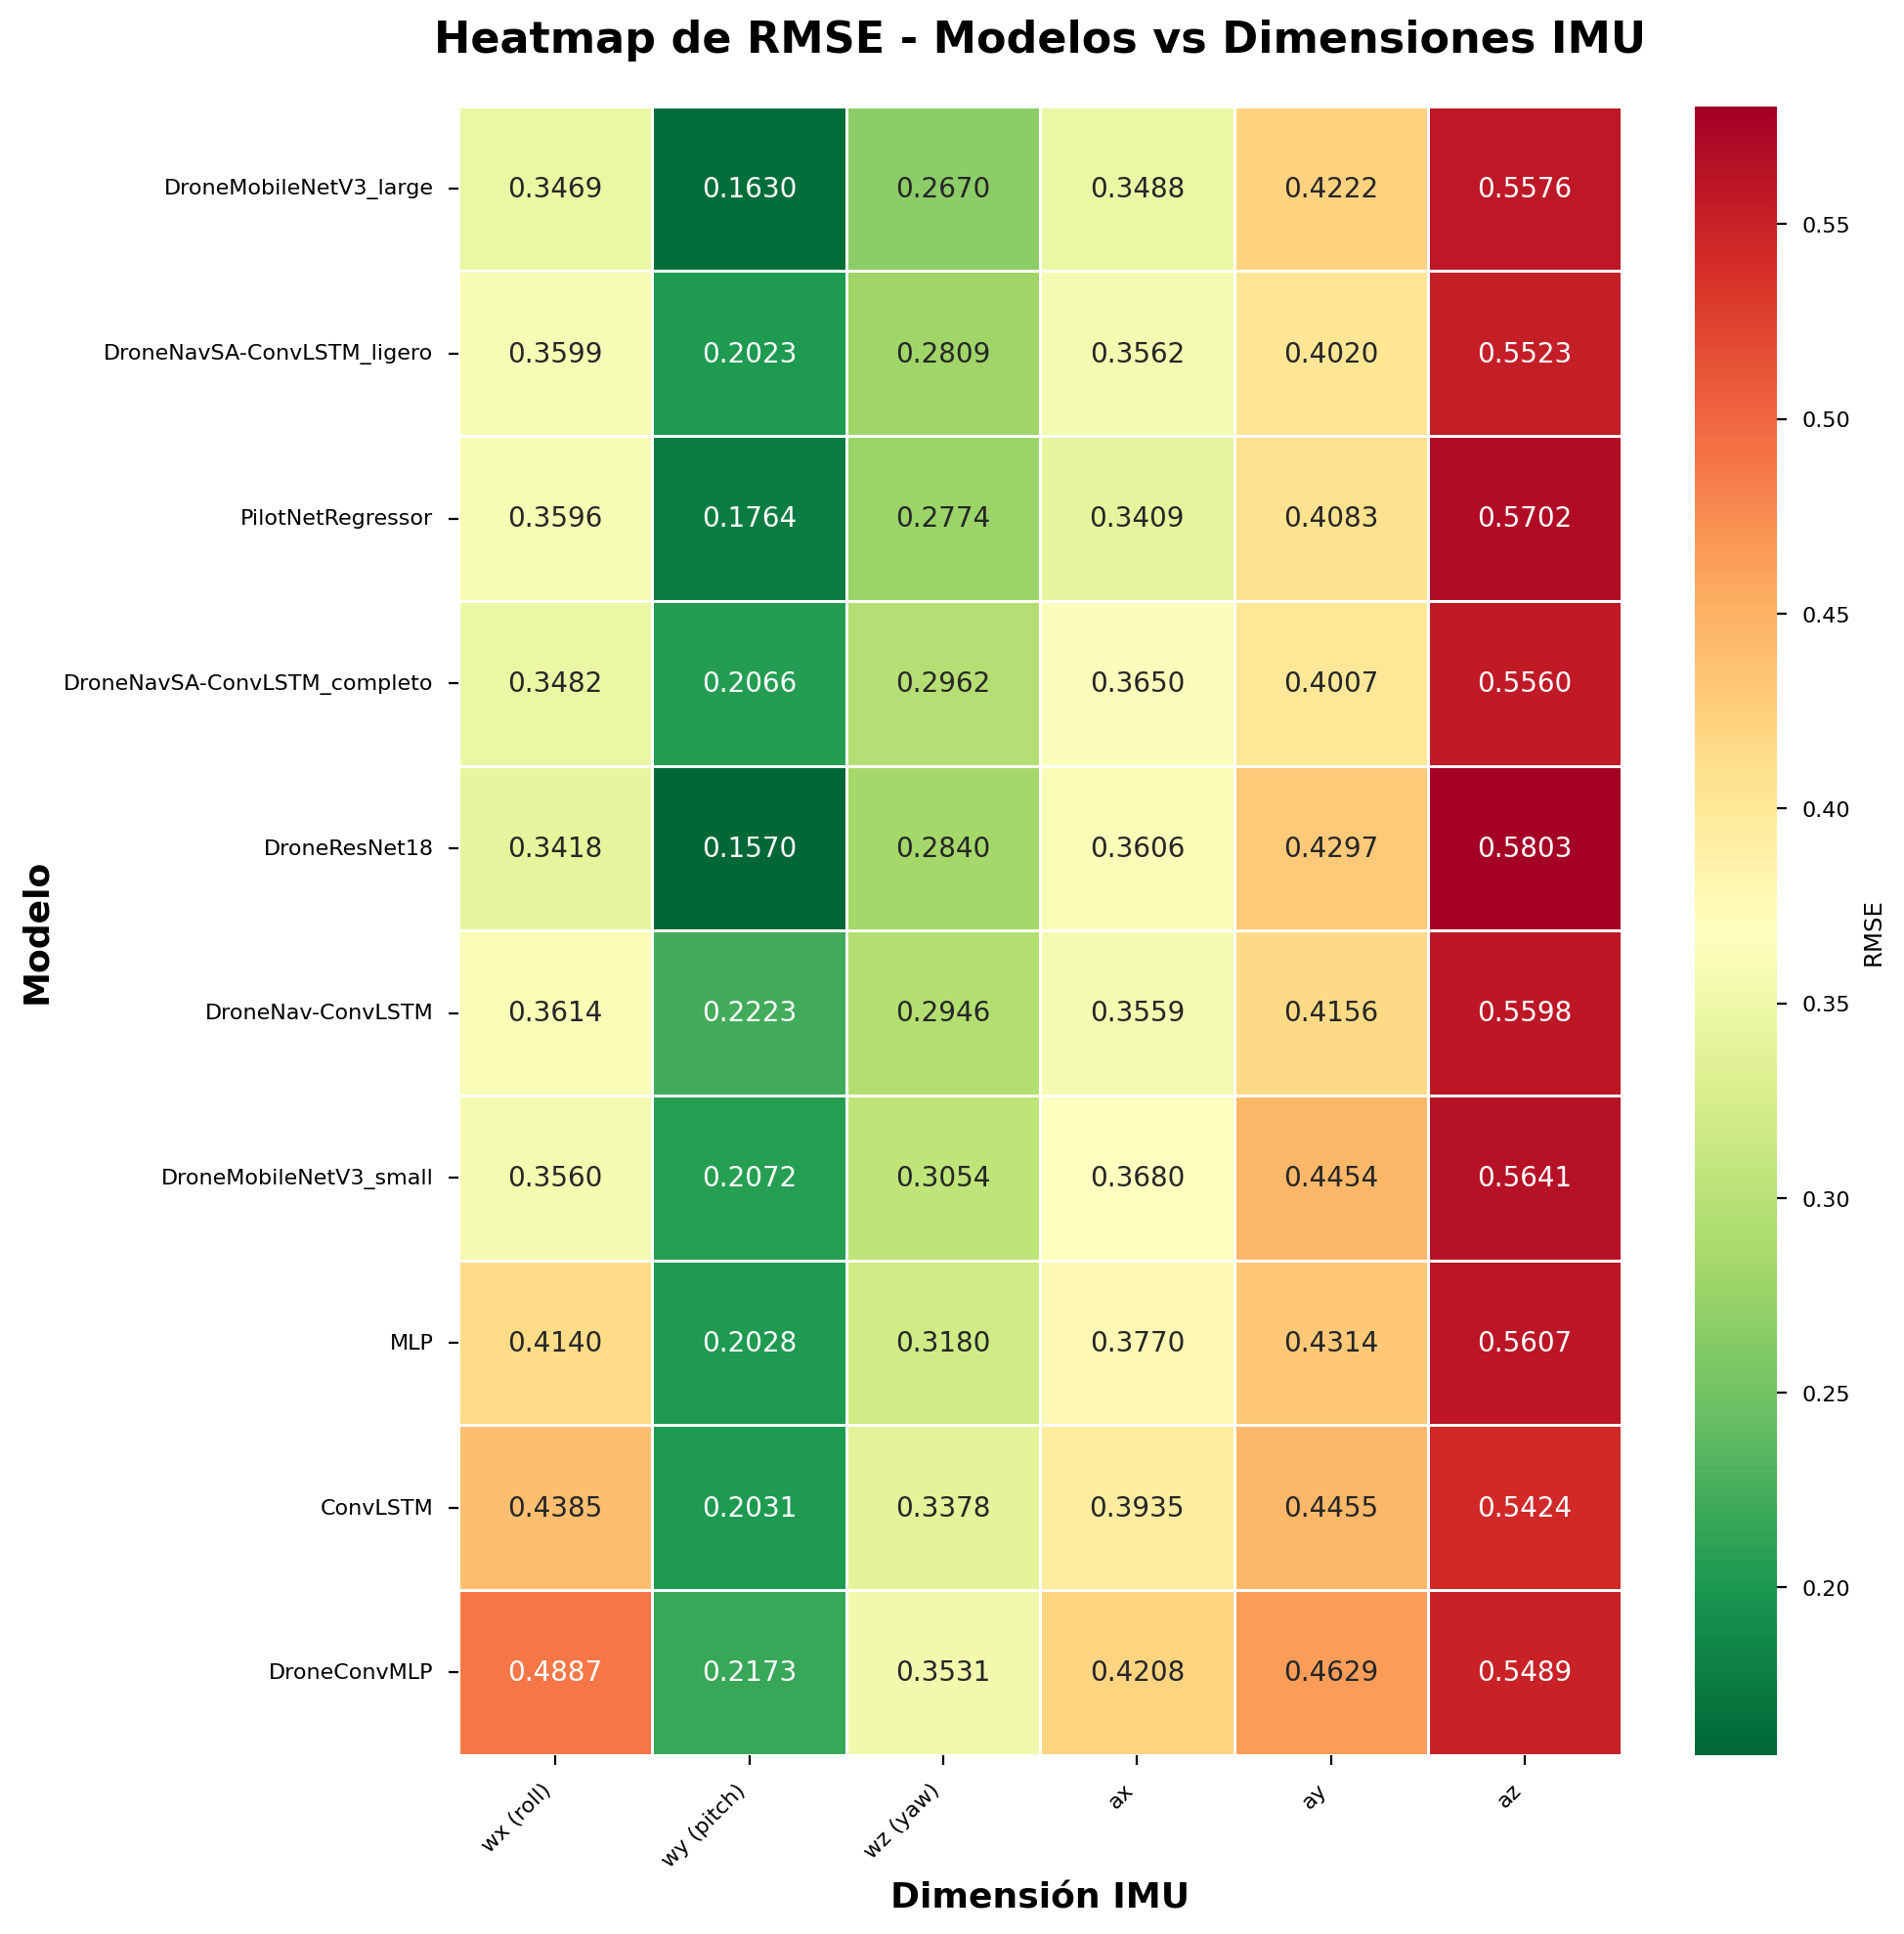

✅ Gráfica guardada: heatmap_rmse.png


In [38]:
# Crear matriz de RMSE por modelo y dimensión
heatmap_data = []
model_names = []

for model_name in df_metrics['Modelo']:
    row = []
    for dim_name in IMU_NAMES:
        rmse = all_results[model_name]['metrics']['per_dimension'][dim_name]['RMSE']
        row.append(rmse)
    heatmap_data.append(row)
    model_names.append(model_name)

heatmap_df = pd.DataFrame(heatmap_data, index=model_names, columns=IMU_NAMES)

# Plotear heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(heatmap_df, annot=True, fmt='.4f', cmap='RdYlGn_r', 
            cbar_kws={'label': 'RMSE'}, linewidths=0.5)
plt.title('Heatmap de RMSE - Modelos vs Dimensiones IMU', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Dimensión IMU', fontsize=13, fontweight='bold')
plt.ylabel('Modelo', fontsize=13, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('heatmap_rmse.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráfica guardada: heatmap_rmse.png")

## 📈 16. Series Temporales de Predicciones (Mejor Modelo)

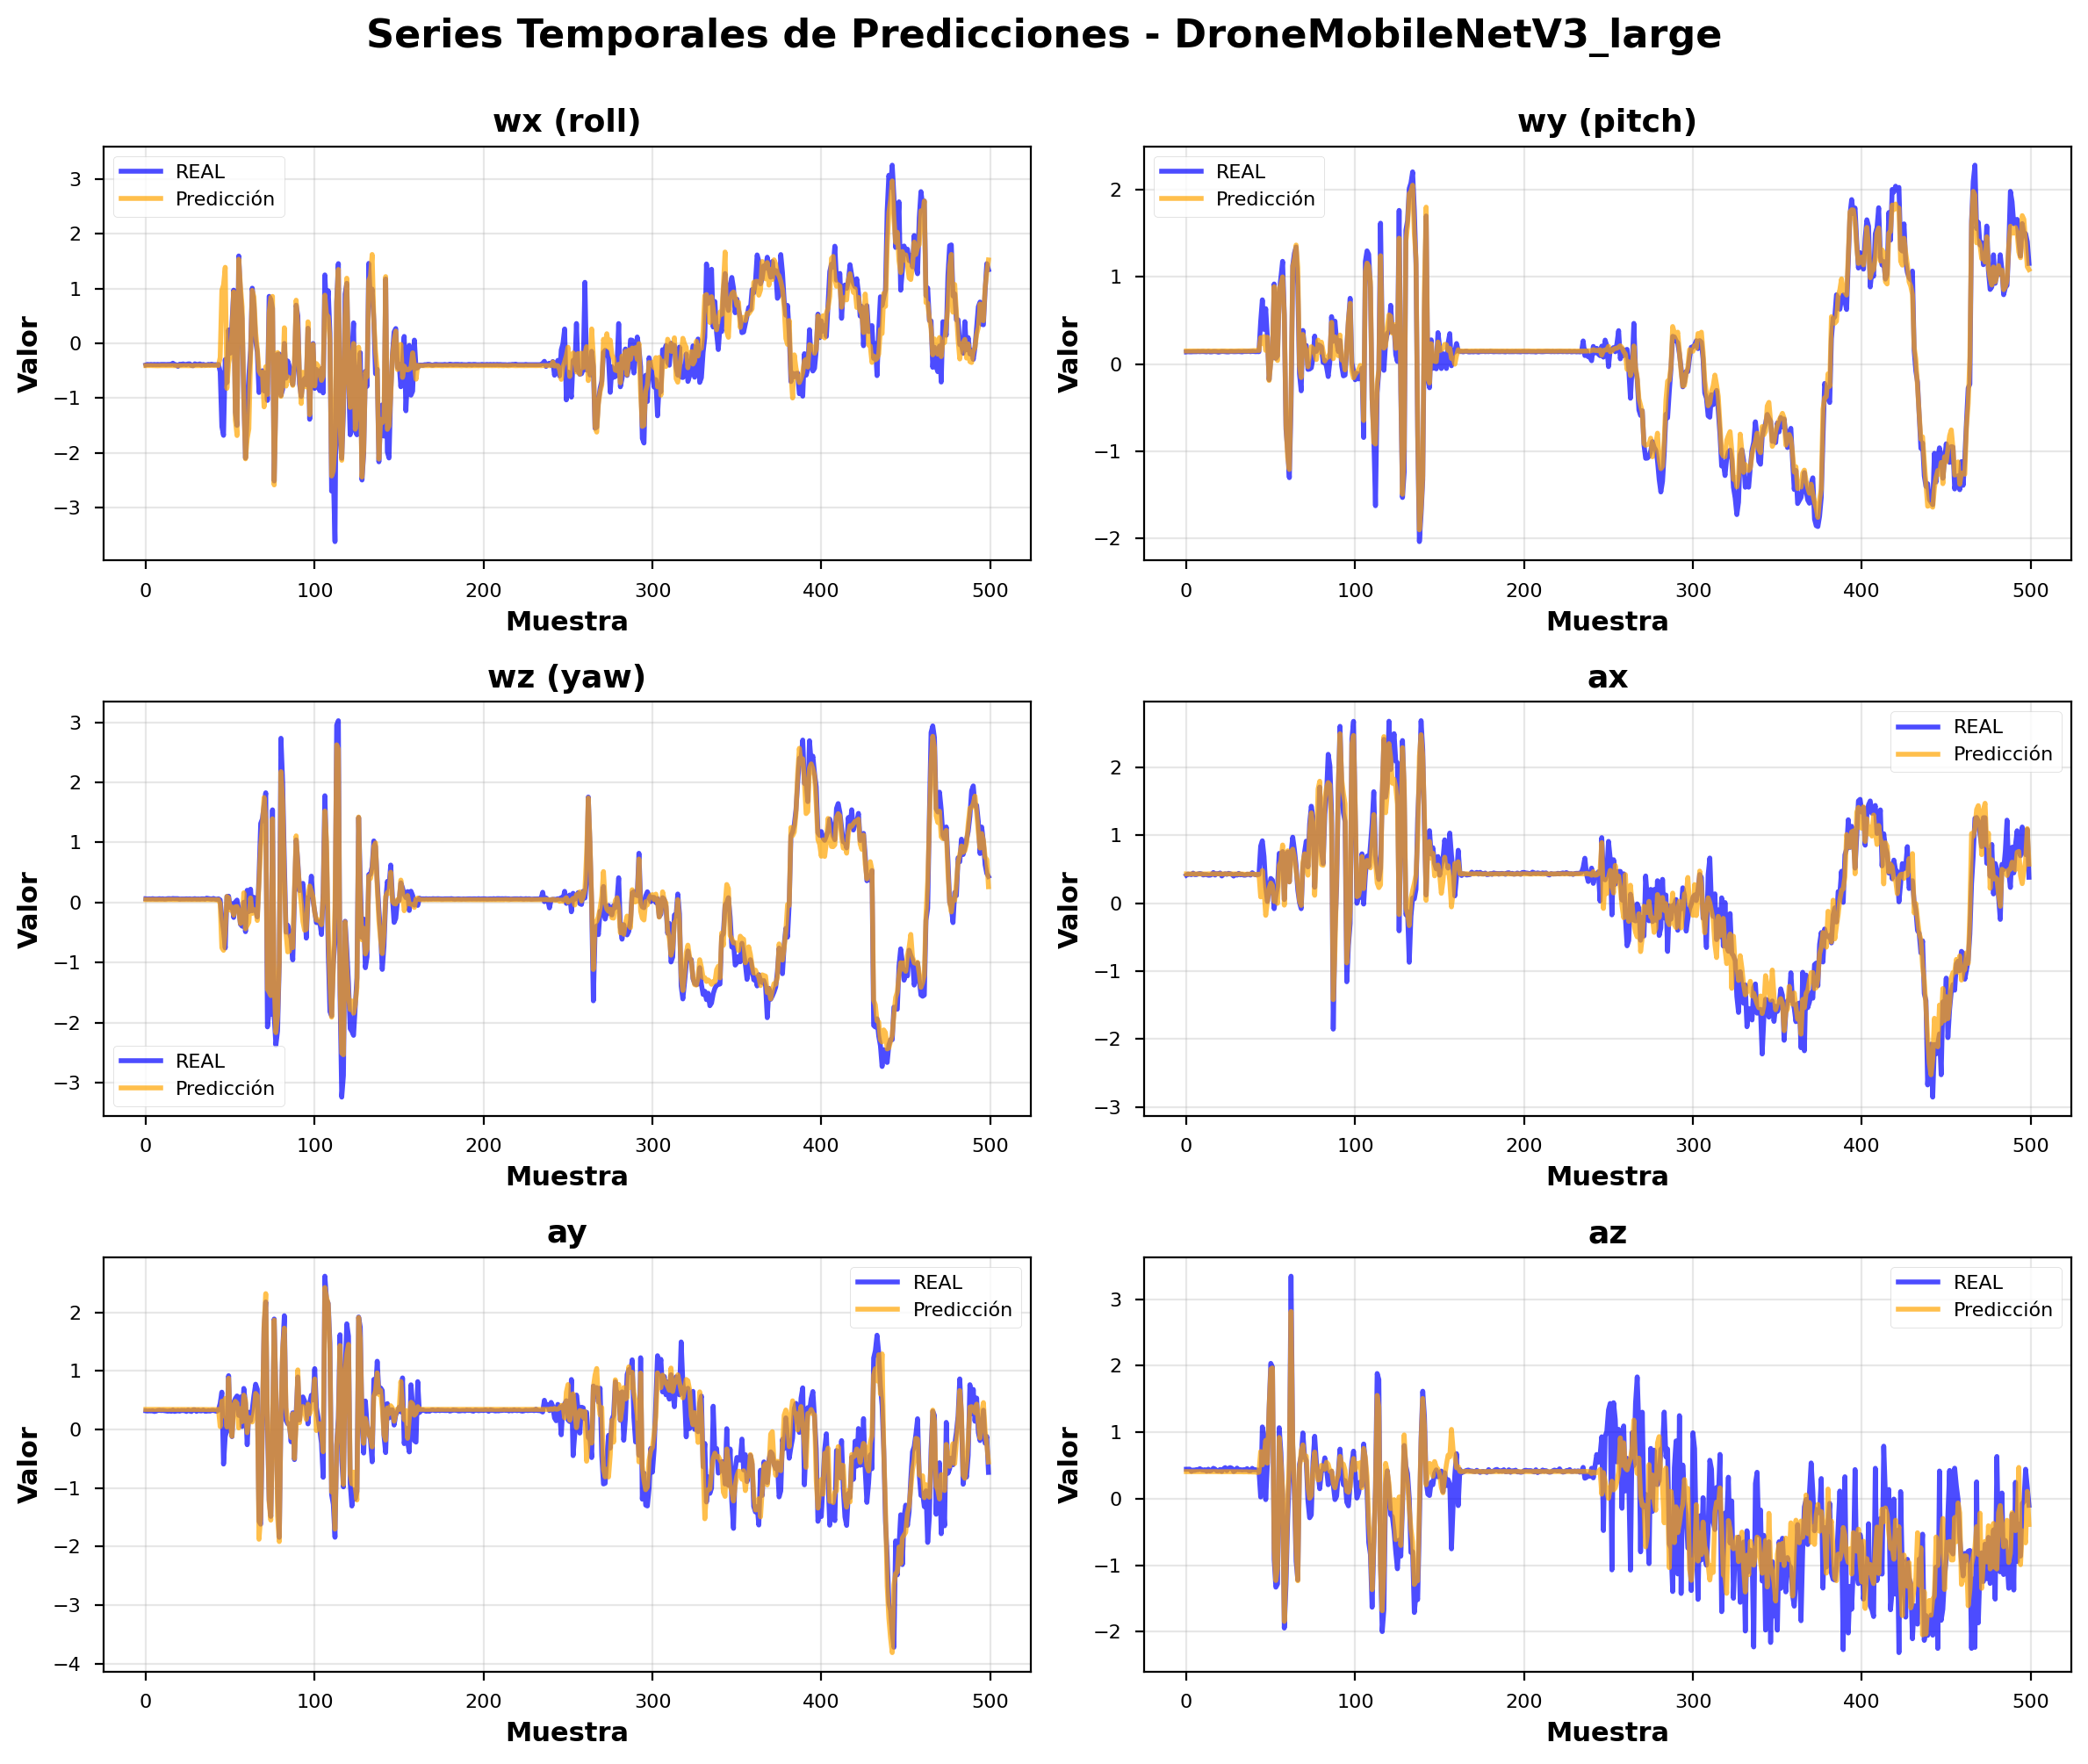

✅ Gráfica guardada: timeseries_DroneMobileNetV3_large.png


In [39]:
# Visualizar predicciones temporales del mejor modelo
best_model_name = df_metrics.iloc[0]['Modelo']
y_true = all_results[best_model_name]['y_true']
y_pred = all_results[best_model_name]['y_pred']

# Seleccionar un segmento representativo (primeras 500 muestras)
n_samples = min(500, len(y_true))

fig, axes = plt.subplots(3, 2, figsize=(12, 10))
axes = axes.flatten()

for i, dim_name in enumerate(IMU_NAMES):
    axes[i].plot(y_true[:n_samples, i], color='blue', label='REAL', linewidth=2, alpha=0.7)
    axes[i].plot(y_pred[:n_samples, i], color='orange',label='Predicción', linewidth=2, alpha=0.7)
    axes[i].set_xlabel('Muestra', fontsize=11, fontweight='bold')
    axes[i].set_ylabel('Valor', fontsize=11, fontweight='bold')
    axes[i].set_title(f'{dim_name}', fontsize=13, fontweight='bold')
    axes[i].legend()
    axes[i].grid(alpha=0.3)

plt.suptitle(f'Series Temporales de Predicciones - {best_model_name}', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(f'timeseries_{best_model_name.replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Gráfica guardada: timeseries_{best_model_name.replace(' ', '_')}.png")

## 📊 17. Análisis Estadístico de Errores

In [40]:
# Crear tabla de estadísticas de errores para el mejor modelo
best_model_name = df_metrics.iloc[0]['Modelo']
y_true = all_results[best_model_name]['y_true']
y_pred = all_results[best_model_name]['y_pred']

error_stats = []

for i, dim_name in enumerate(IMU_NAMES):
    errors = y_true[:, i] - y_pred[:, i]
    abs_errors = np.abs(errors)
    
    error_stats.append({
        'Dimensión': dim_name,
        'Media Error': np.mean(errors),
        'Std Error': np.std(errors),
        'MAE': np.mean(abs_errors),
        'Mediana AE': np.median(abs_errors),
        'P95 AE': np.percentile(abs_errors, 95),
        'Max AE': np.max(abs_errors)
    })

df_error_stats = pd.DataFrame(error_stats)

print(f"\n📊 ESTADÍSTICAS DE ERRORES - {best_model_name}")
print("="*100)
print(df_error_stats.to_string(index=False))
print("="*100)


📊 ESTADÍSTICAS DE ERRORES - DroneMobileNetV3_large
 Dimensión  Media Error  Std Error      MAE  Mediana AE   P95 AE   Max AE
 wx (roll)     0.011134   0.346751 0.202167    0.134089 0.590731 7.912964
wy (pitch)    -0.016219   0.162157 0.105776    0.075712 0.296981 3.114128
  wz (yaw)    -0.005414   0.266926 0.130115    0.085896 0.376677 7.191231
        ax    -0.015616   0.348422 0.235761    0.168023 0.700288 4.825902
        ay    -0.001674   0.422215 0.232448    0.155679 0.661587 8.606793
        az    -0.004576   0.557586 0.380094    0.239886 1.215735 3.271472


## 🎯 18. Matriz de Correlación de Errores

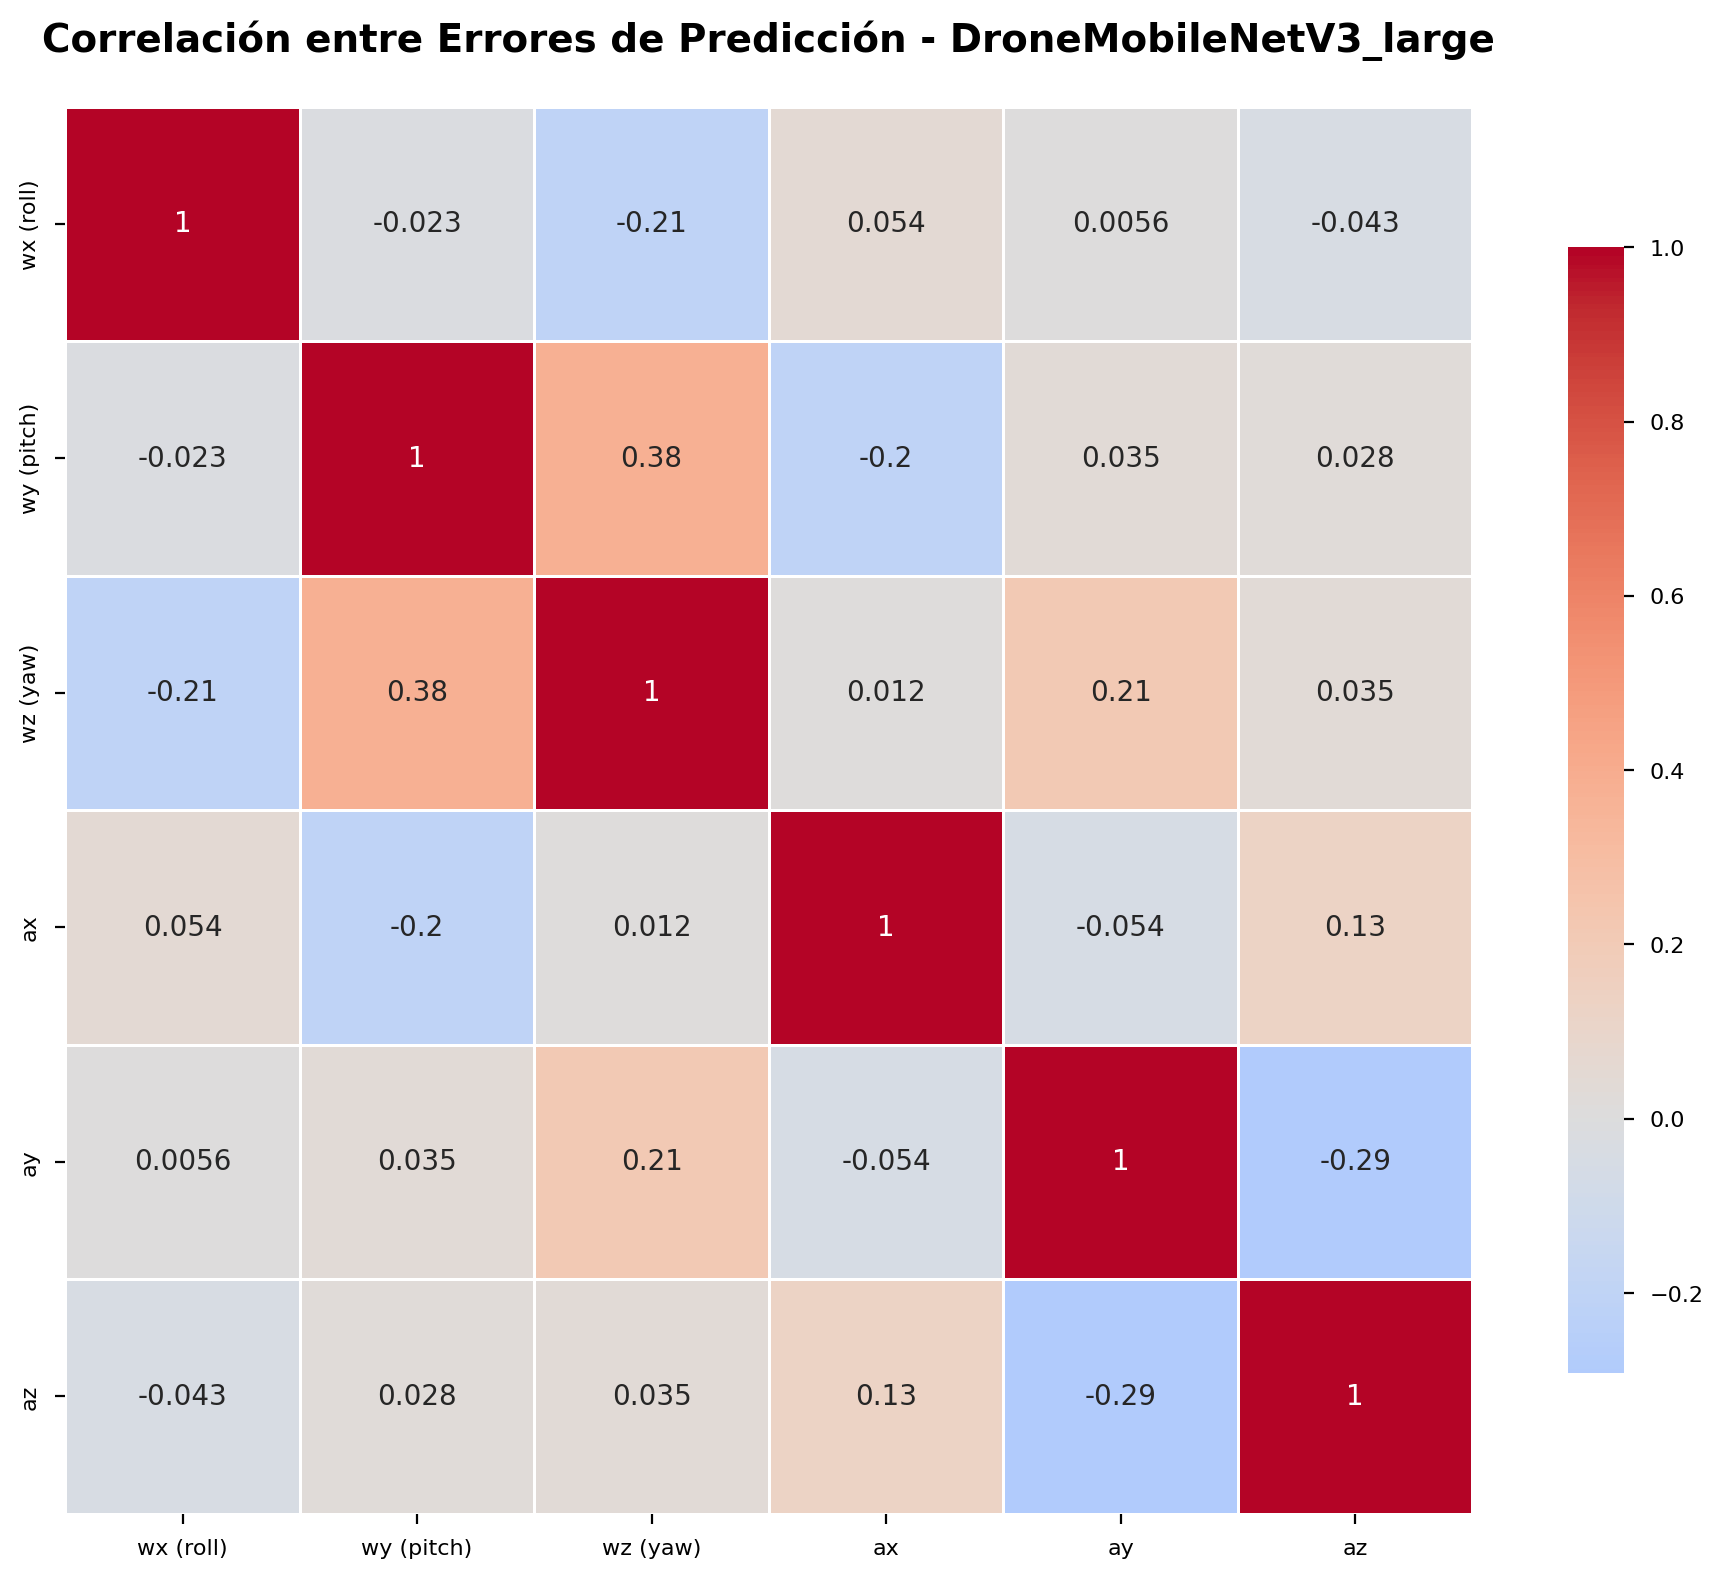

✅ Gráfica guardada: error_correlation.png


In [41]:
# Analizar correlación entre errores de diferentes dimensiones
best_model_name = df_metrics.iloc[0]['Modelo']
y_true = all_results[best_model_name]['y_true']
y_pred = all_results[best_model_name]['y_pred']

errors = y_true - y_pred
error_df = pd.DataFrame(errors, columns=IMU_NAMES)
correlation_matrix = error_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title(f'Correlación entre Errores de Predicción - {best_model_name}', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('error_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráfica guardada: error_correlation.png")

## 📊 19. Histogramas de Distribución de Errores

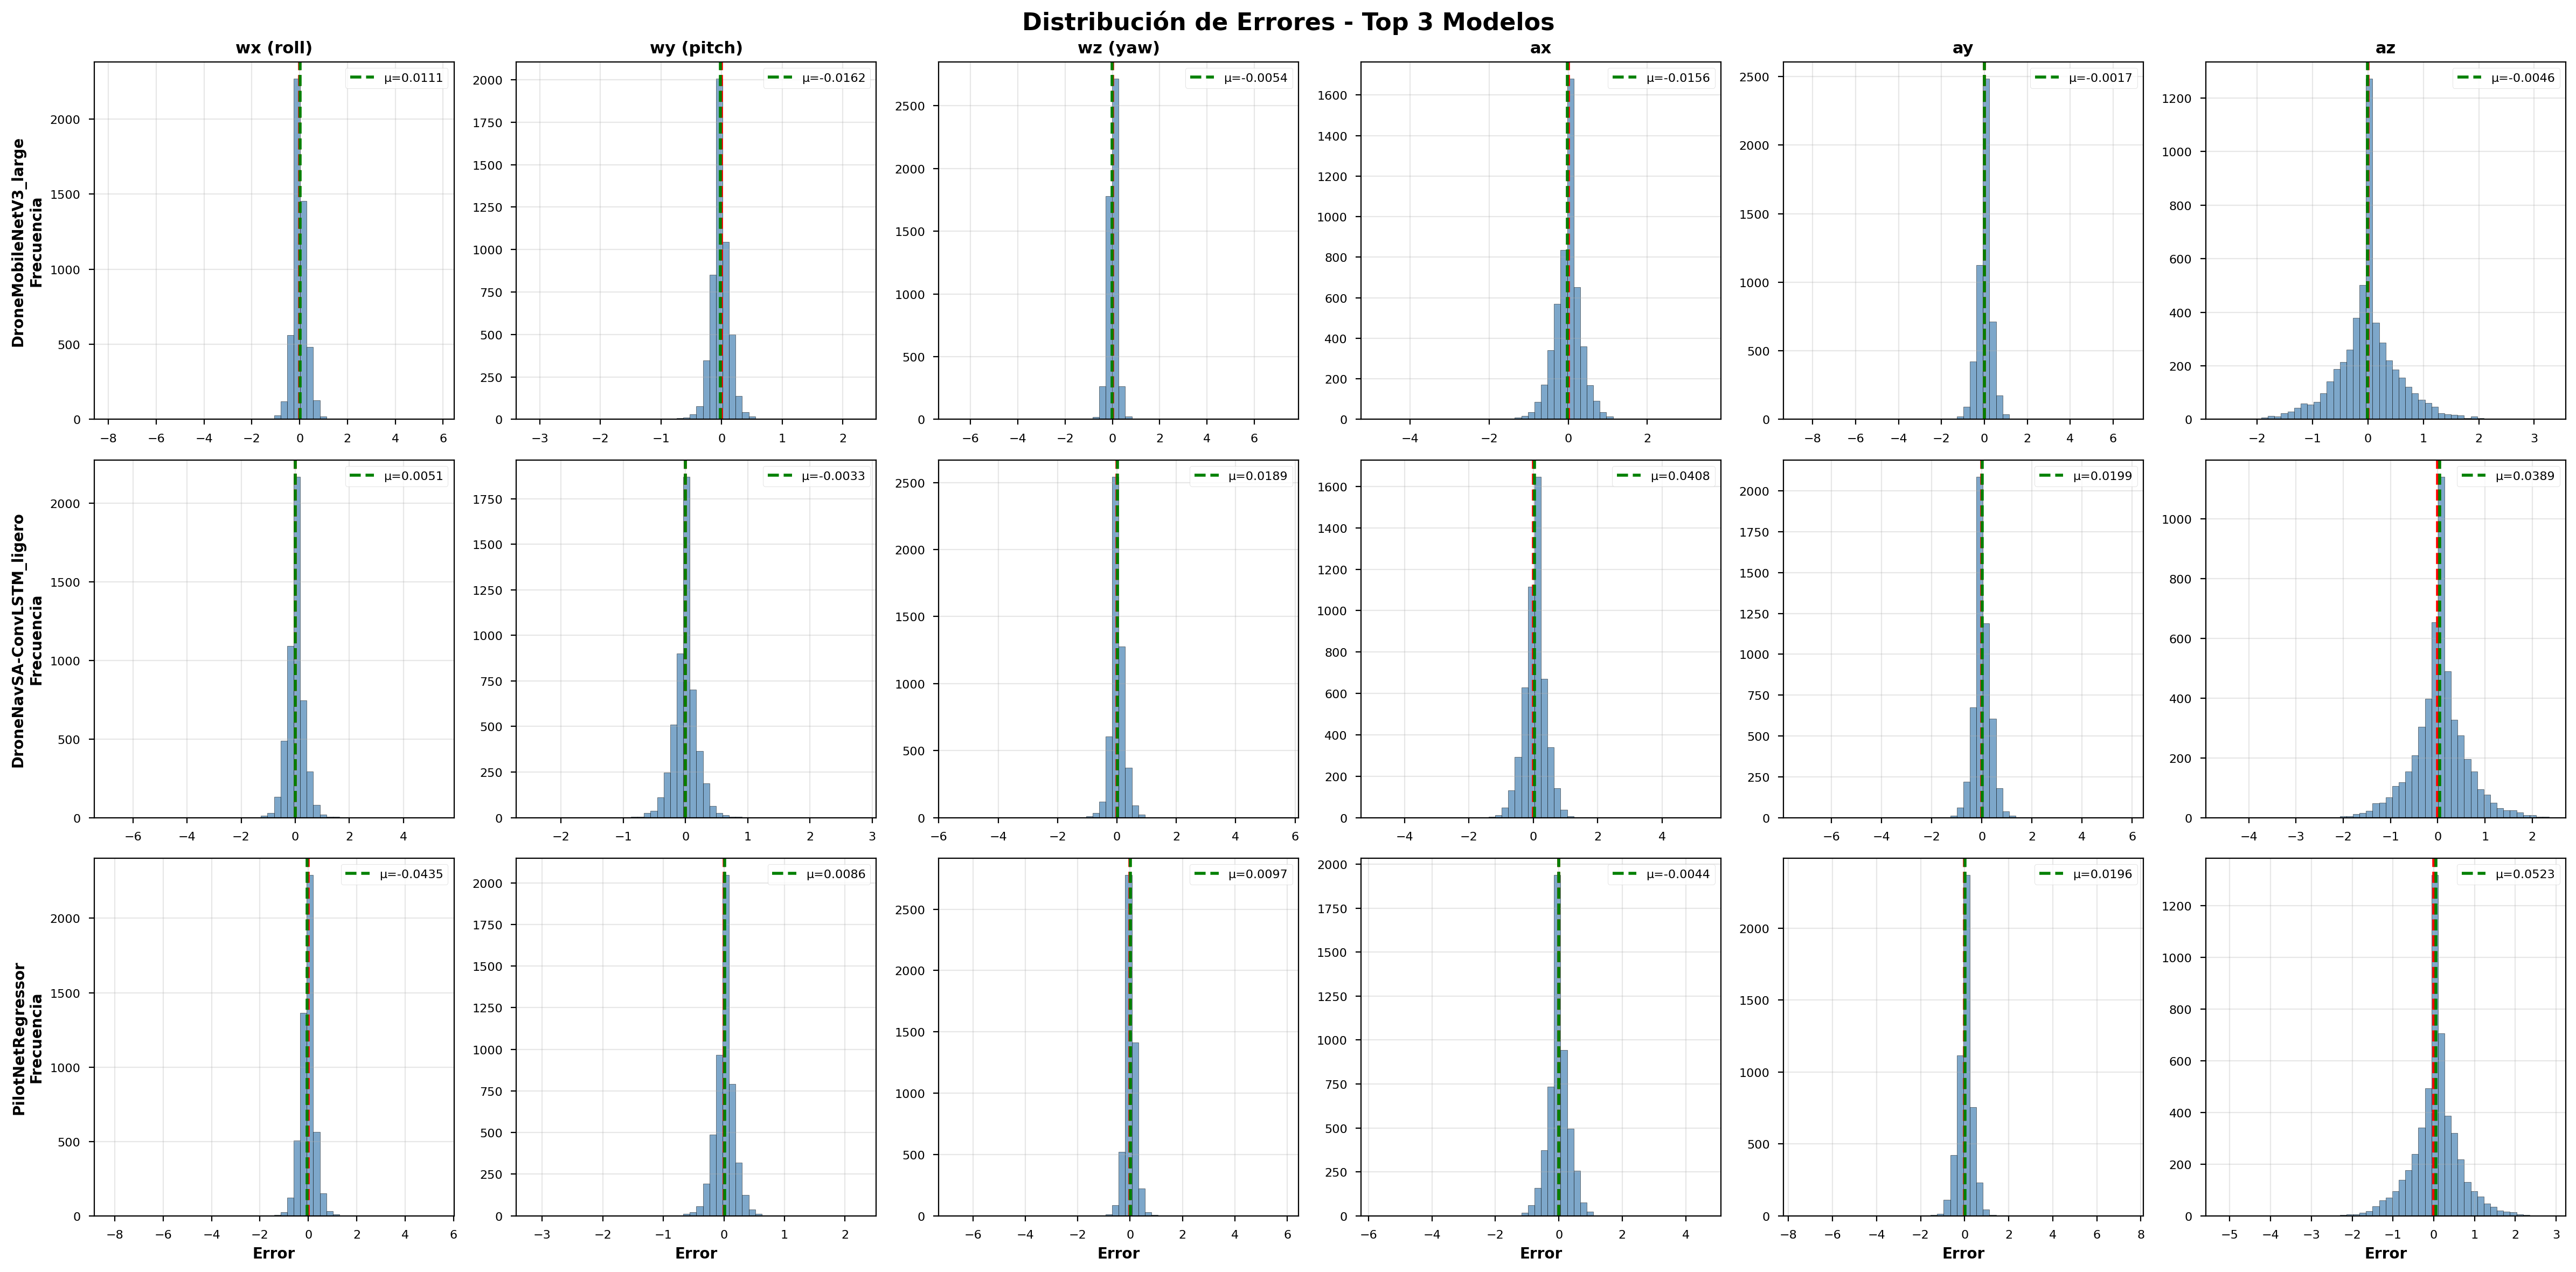

✅ Gráfica guardada: error_histograms.png


In [42]:
# Histogramas de errores para top 3 modelos
top_3_models = df_metrics.head(3)['Modelo'].tolist()

fig, axes = plt.subplots(3, 6, figsize=(24, 12))

for row, model_name in enumerate(top_3_models):
    y_true = all_results[model_name]['y_true']
    y_pred = all_results[model_name]['y_pred']
    
    for col, dim_name in enumerate(IMU_NAMES):
        errors = y_true[:, col] - y_pred[:, col]
        
        axes[row, col].hist(errors, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
        axes[row, col].axvline(0, color='red', linestyle='--', linewidth=2)
        axes[row, col].axvline(np.mean(errors), color='green', linestyle='--', linewidth=2, 
                               label=f'μ={np.mean(errors):.4f}')
        
        if row == 0:
            axes[row, col].set_title(f'{dim_name}', fontsize=11, fontweight='bold')
        if col == 0:
            axes[row, col].set_ylabel(f'{model_name}\nFrecuencia', fontsize=10, fontweight='bold')
        if row == 2:
            axes[row, col].set_xlabel('Error', fontsize=10, fontweight='bold')
        
        axes[row, col].legend(fontsize=8)
        axes[row, col].grid(alpha=0.3)

plt.suptitle('Distribución de Errores - Top 3 Modelos', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('error_histograms.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráfica guardada: error_histograms.png")

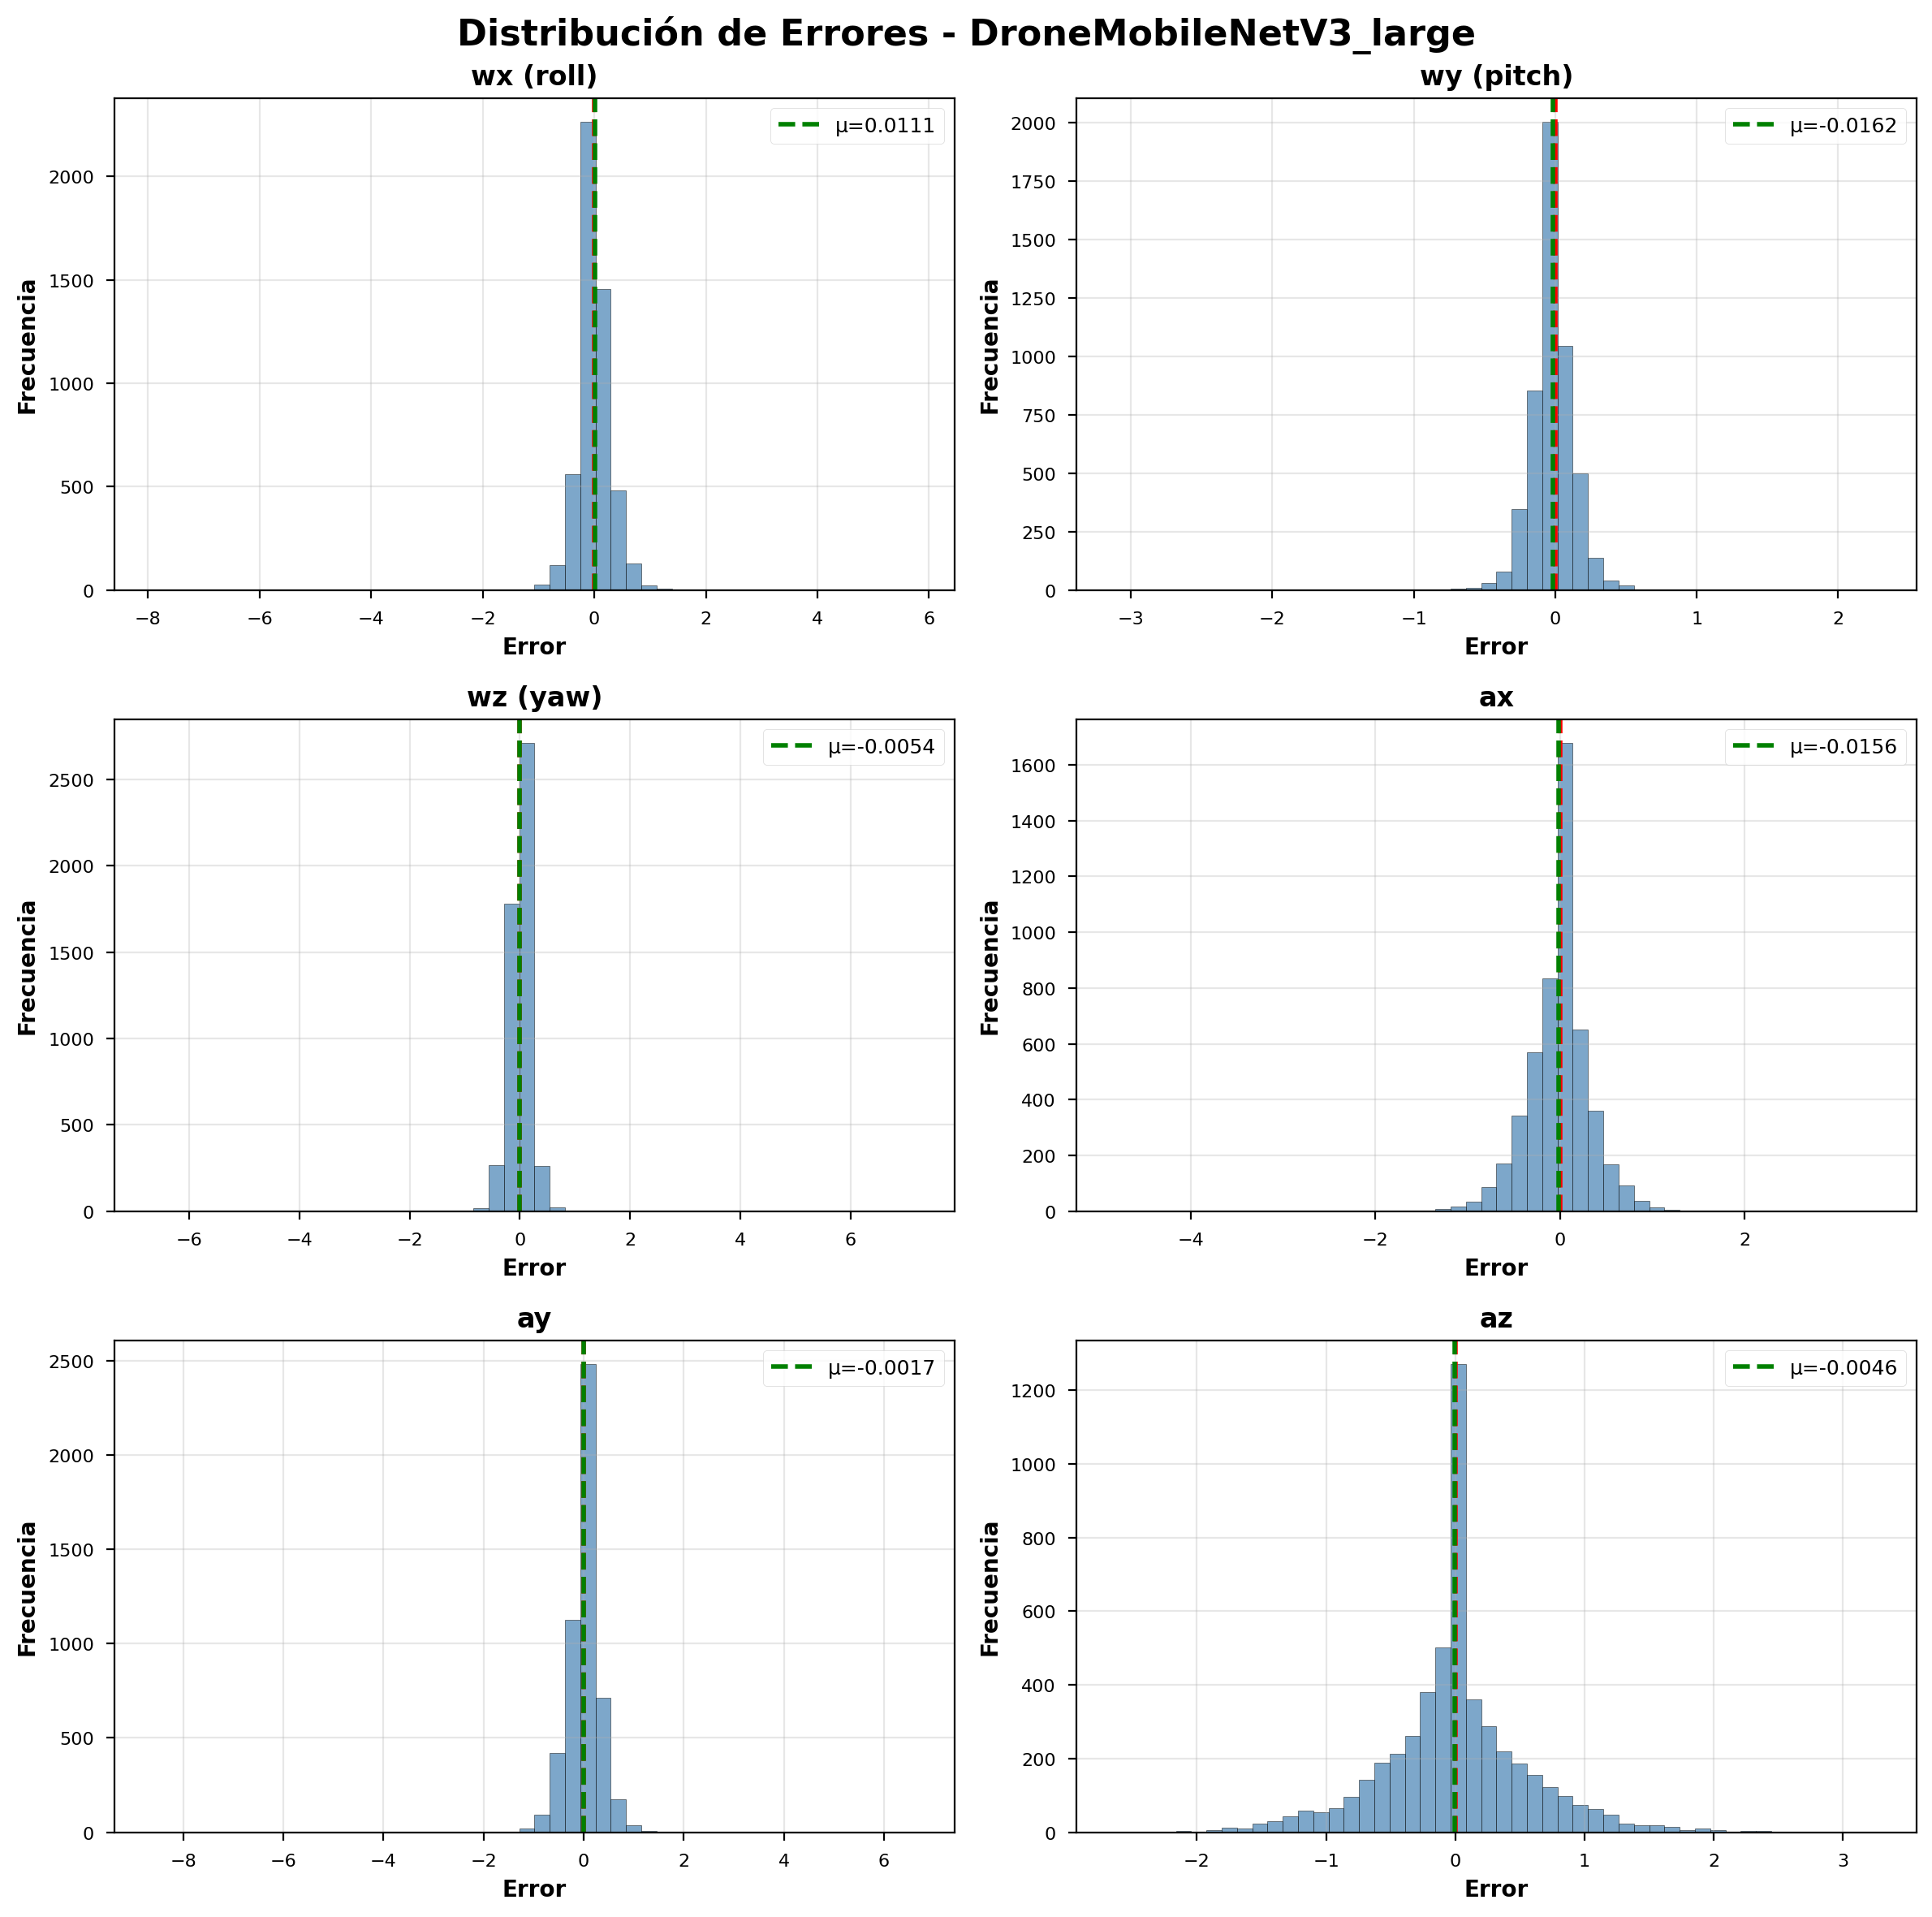

✅ Gráfica guardada: error_histograms_best.png (Modelo: DroneMobileNetV3_large)


In [50]:
# Histogramas de errores solo para el mejor modelo (3x2)
best_model = df_metrics.head(1)['Modelo'].iloc[0]

fig, axes = plt.subplots(3, 2, figsize=(12, 12))

y_true = all_results[best_model]['y_true']
y_pred = all_results[best_model]['y_pred']

for idx, dim_name in enumerate(IMU_NAMES):
    row = idx // 2
    col = idx % 2
    
    errors = y_true[:, idx] - y_pred[:, idx]
    
    axes[row, col].hist(errors, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
    axes[row, col].axvline(0, color='red', linestyle='--', linewidth=2)
    axes[row, col].axvline(np.mean(errors), color='green', linestyle='--', linewidth=2, 
                           label=f'μ={np.mean(errors):.4f}')
    
    axes[row, col].set_title(f'{dim_name}', fontsize=12, fontweight='bold')
    axes[row, col].set_xlabel('Error', fontsize=10, fontweight='bold')
    axes[row, col].set_ylabel('Frecuencia', fontsize=10, fontweight='bold')
    
    axes[row, col].legend(fontsize=9)
    axes[row, col].grid(alpha=0.3)

plt.suptitle(f'Distribución de Errores - {best_model}', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('error_histograms_best.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Gráfica guardada: error_histograms_best.png (Modelo: {best_model})")

## 💾 20. Guardar Resultados

In [20]:
# Guardar métricas en CSV
df_metrics.to_csv('model_comparison_global_metrics.csv', index=False)
print("✅ Guardado: model_comparison_global_metrics.csv")

df_dim_metrics.to_csv('model_comparison_per_dimension.csv', index=False)
print("✅ Guardado: model_comparison_per_dimension.csv")

# Guardar resumen en texto
with open('evaluation_summary.txt', 'w') as f:
    f.write("="*80 + "\n")
    f.write("RESUMEN DE EVALUACIÓN DE MODELOS\n")
    f.write("="*80 + "\n\n")
    
    f.write(f"Total de modelos evaluados: {len(all_results)}\n")
    f.write(f"Total de muestras de test: {len(X_img_test)}\n\n")
    
    f.write("RANKING DE MODELOS (por RMSE):\n")
    f.write("-"*80 + "\n")
    for idx, row in df_metrics.iterrows():
        multi_step_tag = " [Multi-Step]" if row['Multi-Step'] == '✓' else ""
        f.write(f"{idx+1}. {row['Modelo']}{multi_step_tag}\n")
        f.write(f"   RMSE: {row['RMSE']:.6f}\n")
        f.write(f"   MAE:  {row['MAE']:.6f}\n")
        f.write(f"   R²:   {row['R²']:.6f}\n\n")
    
    f.write("="*80 + "\n")
    f.write(f"MEJOR MODELO: {best_model}\n")
    f.write("="*80 + "\n")

print("✅ Guardado: evaluation_summary.txt")

print("\n🎉 EVALUACIÓN COMPLETADA EXITOSAMENTE")

✅ Guardado: model_comparison_global_metrics.csv
✅ Guardado: model_comparison_per_dimension.csv
✅ Guardado: evaluation_summary.txt

🎉 EVALUACIÓN COMPLETADA EXITOSAMENTE


## 🎯 21. Análisis de Casos Extremos


🔍 ANÁLISIS DE CASOS EXTREMOS - DroneMobileNetV3_large

Índices de las 10 peores predicciones:
1. Índice: 5063, Error Euclidiano: 11.700133
   Ground Truth: [-4.7772965  -0.23953481 -4.650667   -5.0055594  -3.9431875  -0.68484634]
   Predicción:   [-2.5489175   1.1924938   1.700431   -0.17965677  4.1940227  -0.8765575 ]
   Diferencia:   [-2.228379   -1.4320287  -6.351098   -4.8259025  -8.13721     0.19171119]

2. Índice: 5066, Error Euclidiano: 11.582328
   Ground Truth: [-4.476953   2.1222577  5.0176935 -2.1246376  4.686628   2.0879343]
   Predicción:   [ 3.4360108   0.32310572 -2.173537   -0.8286764   0.92296445  1.2277642 ]
   Diferencia:   [-7.912964   1.799152   7.191231  -1.2959611  3.7636633  0.86017  ]

3. Índice: 1407, Error Euclidiano: 11.327443
   Ground Truth: [ 1.8398837 -1.0594867 -5.014743  -2.0887184 -4.6803145  2.314342 ]
   Predicción:   [ 1.9961181e-03 -4.6214306e-01  1.6429181e+00 -1.1108343e-01
  3.9264791e+00  8.0970222e-01]
   Diferencia:   [ 1.8378875 -0.5973437

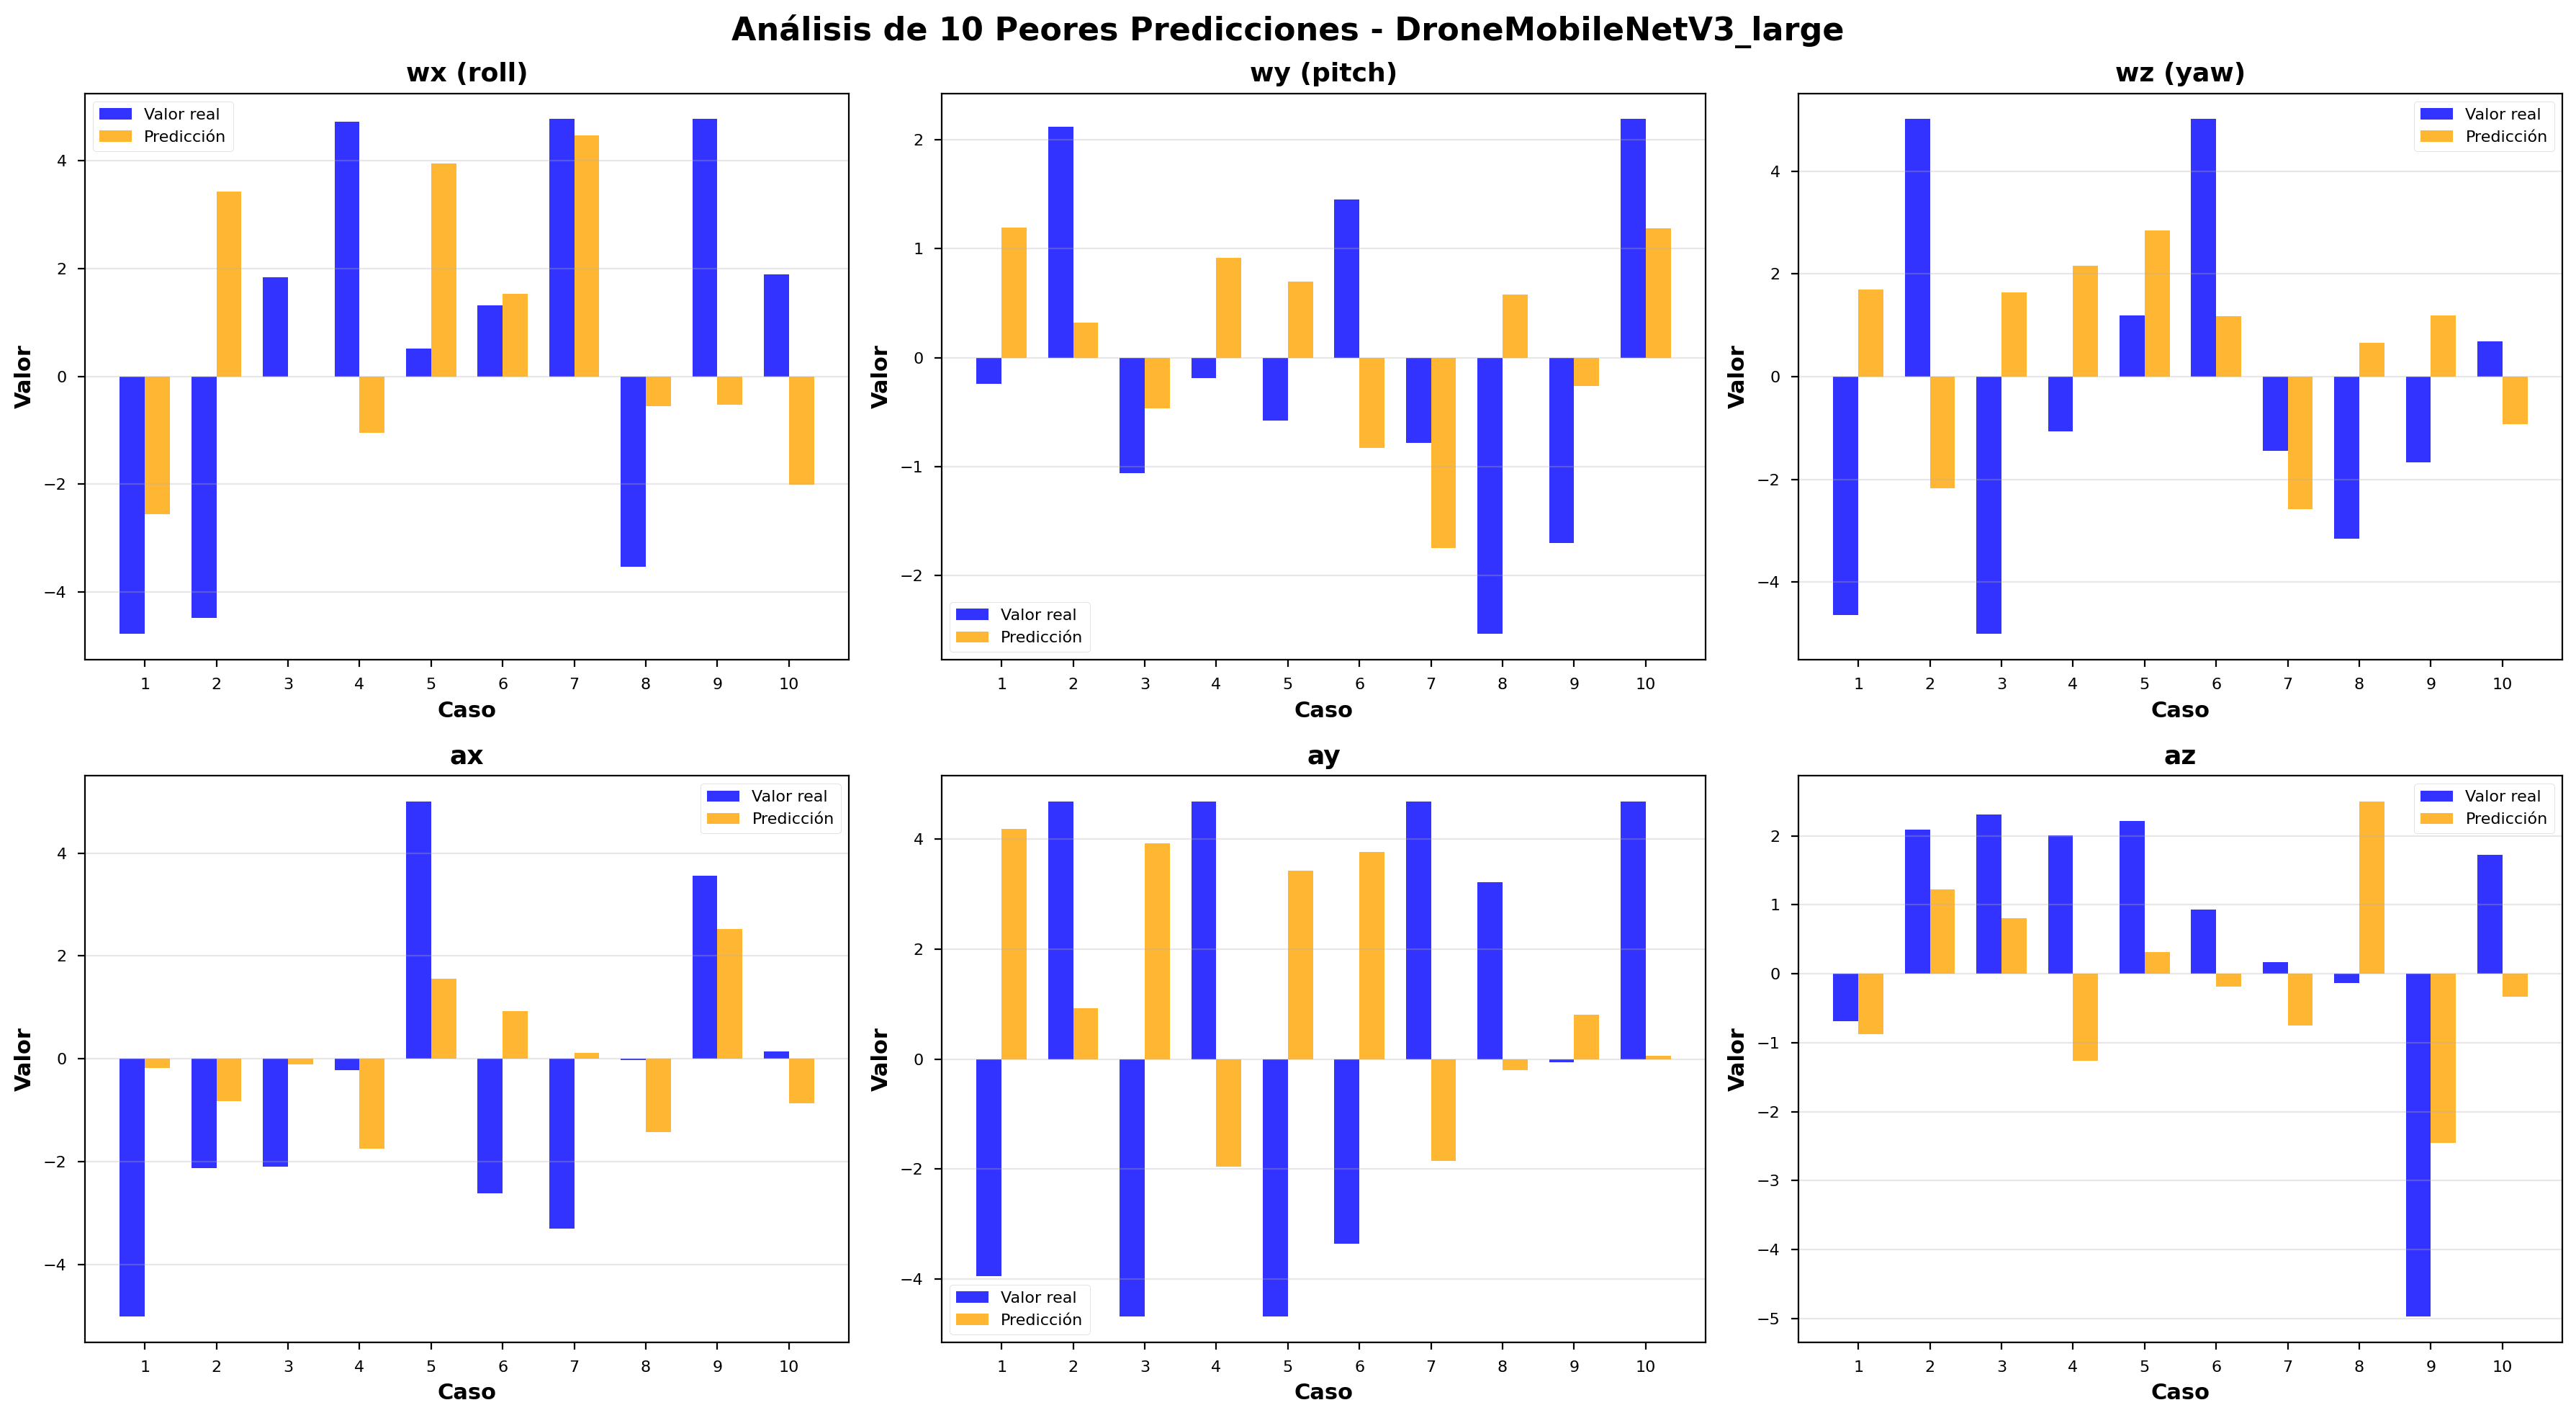

✅ Gráfica guardada: worst_cases_analysis.png


In [ ]:
# Identificar las 10 peores predicciones del mejor modelo
best_model_name = df_metrics.iloc[0]['Modelo']
y_true = all_results[best_model_name]['y_true']
y_pred = all_results[best_model_name]['y_pred']

# Calcular error total por muestra (norma euclidiana)
sample_errors = np.linalg.norm(y_true - y_pred, axis=1)
worst_indices = np.argsort(sample_errors)[-10:][::-1]

print(f"\n🔍 ANÁLISIS DE CASOS EXTREMOS - {best_model_name}")
print("="*80)
print("\nÍndices de las 10 peores predicciones:")
for i, idx in enumerate(worst_indices, 1):
    print(f"{i}. Índice: {idx}, Error Euclidiano: {sample_errors[idx]:.6f}")
    print(f"   Ground Truth: {y_true[idx]}")
    print(f"   Predicción:   {y_pred[idx]}")
    print(f"   Diferencia:   {y_true[idx] - y_pred[idx]}")
    print()

# Visualizar casos extremos
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, dim_name in enumerate(IMU_NAMES):
    # Valores de los peores casos
    worst_true = y_true[worst_indices, i]
    worst_pred = y_pred[worst_indices, i]
    
    x = np.arange(len(worst_indices))
    width = 0.35
    
    axes[i].bar(x - width/2, worst_true, width, color='blue', label='Real', alpha=0.8)
    axes[i].bar(x + width/2, worst_pred, width, color='orange',label='Predicción', alpha=0.8)
    
    axes[i].set_xlabel('Caso', fontsize=11, fontweight='bold')
    axes[i].set_ylabel('Valor', fontsize=11, fontweight='bold')
    axes[i].set_title(f'{dim_name}', fontsize=13, fontweight='bold')
    axes[i].set_xticks(x)
    axes[i].set_xticklabels([f'{i+1}' for i in range(len(worst_indices))])
    axes[i].legend()
    axes[i].grid(axis='y', alpha=0.3)

plt.suptitle(f'Análisis de 10 Peores Predicciones - {best_model_name}', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('worst_cases_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráfica guardada: worst_cases_analysis.png")

## 📊 22. Comparación Radar Chart

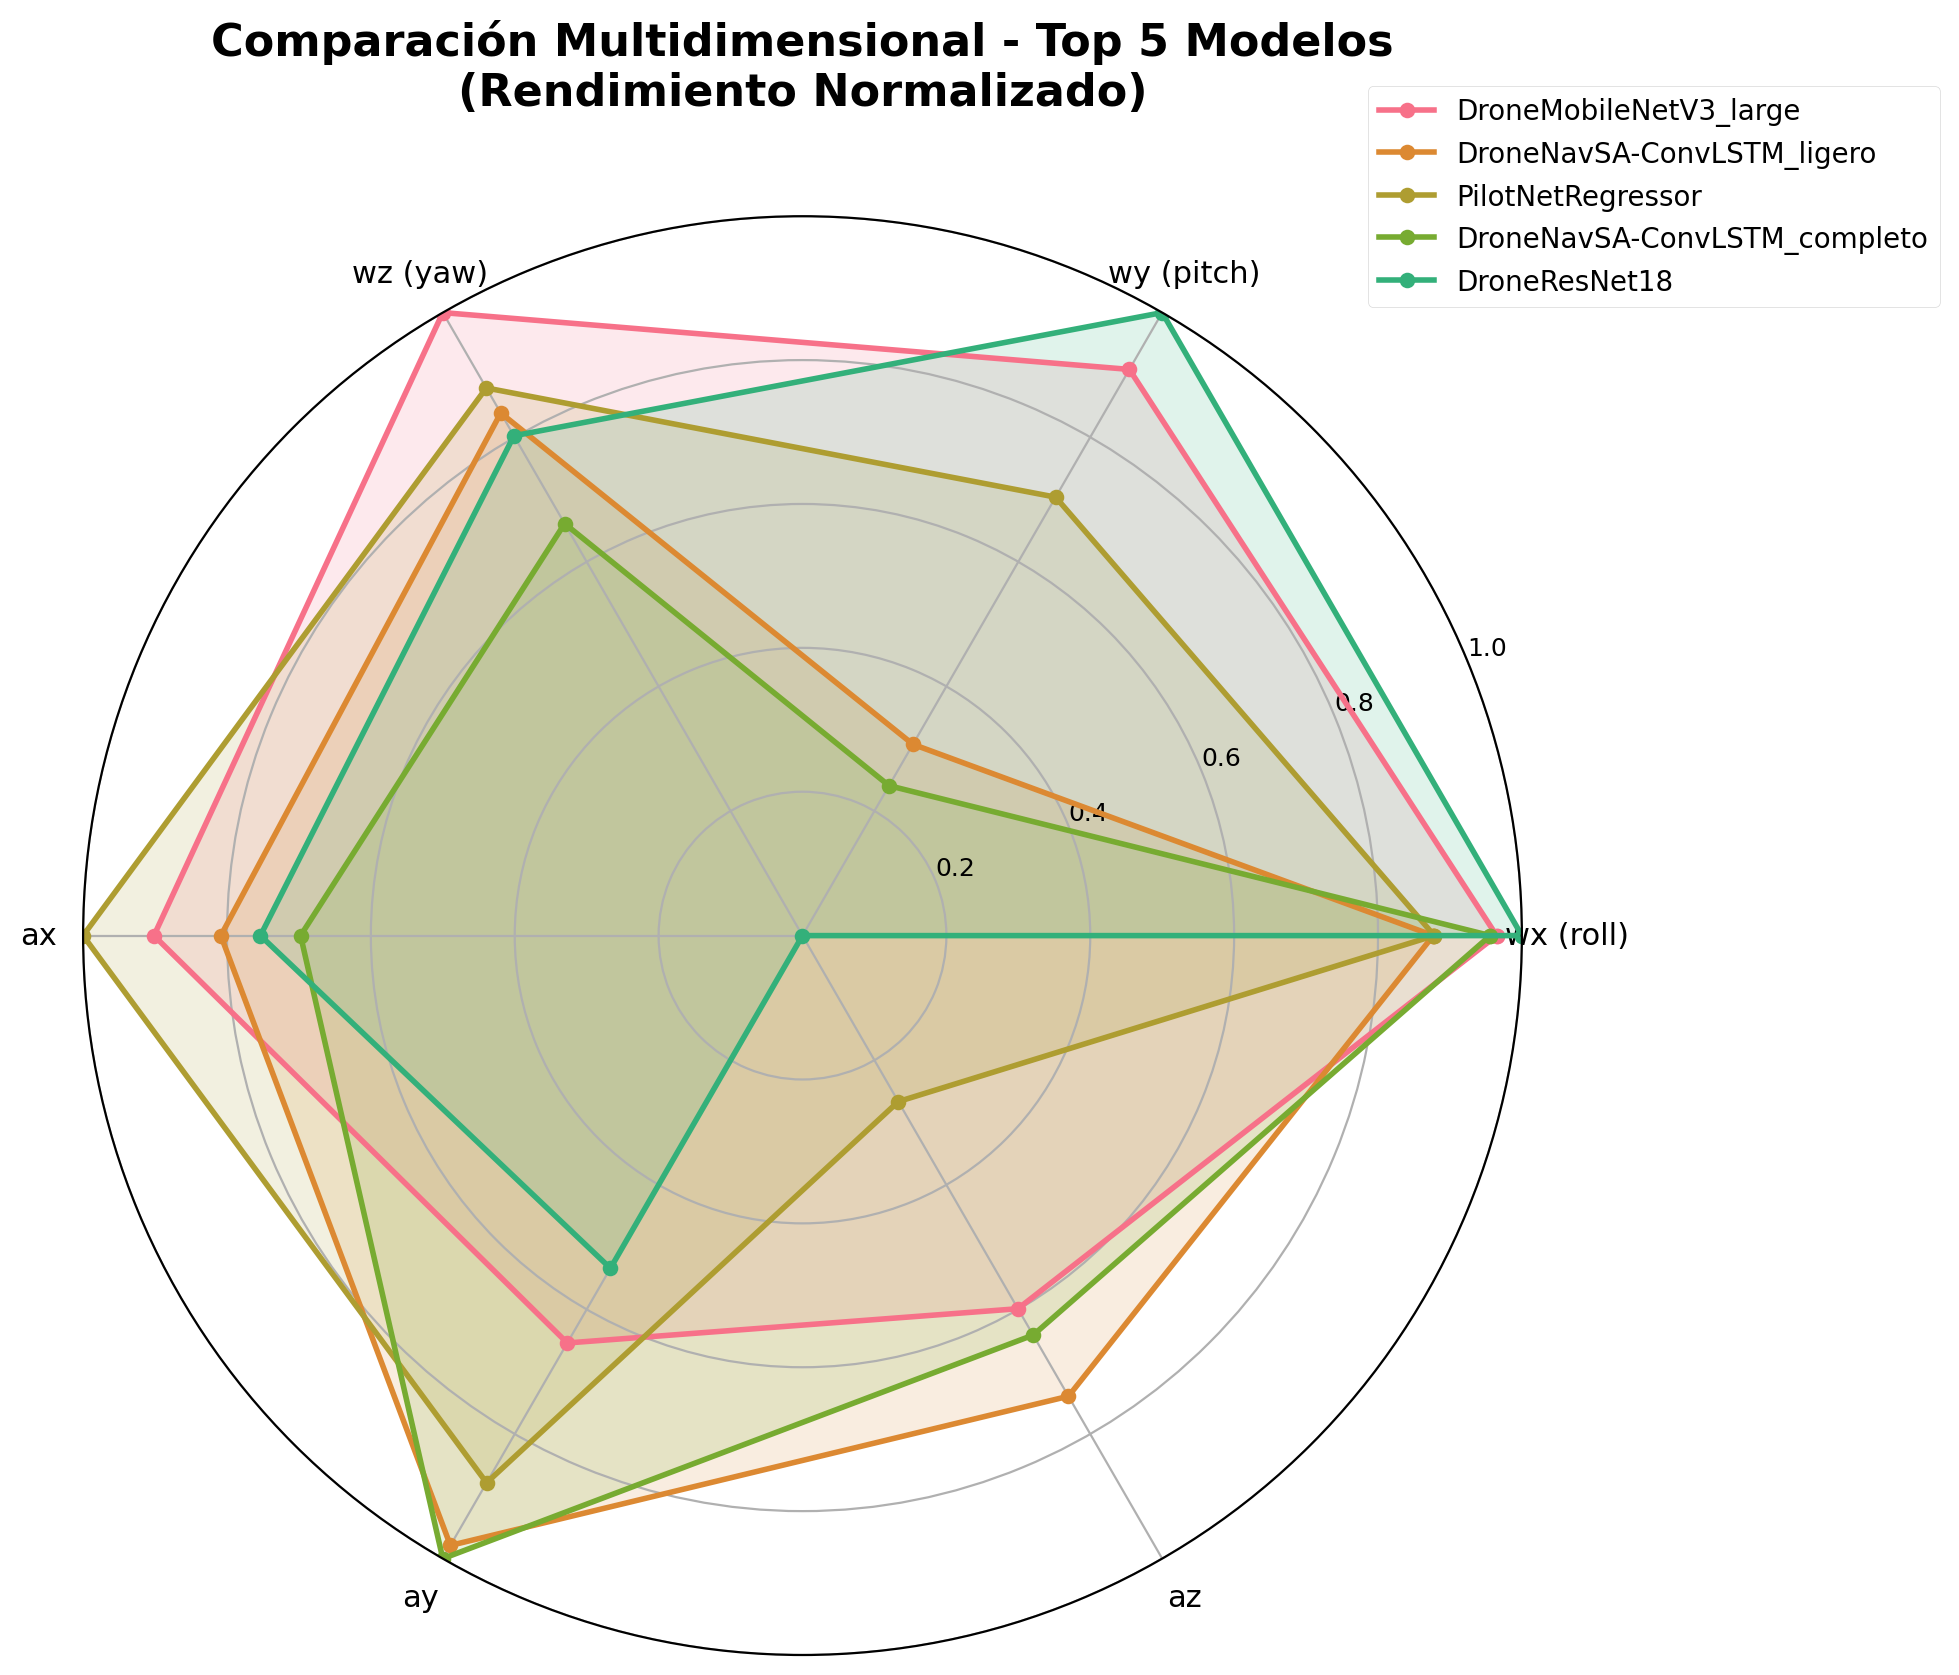

✅ Gráfica guardada: radar_comparison.png


In [22]:
# Crear radar chart para comparar modelos en diferentes dimensiones
from math import pi

# Normalizar RMSE por dimensión (0-1) para mejor visualización
normalized_rmse = {}
for dim_name in IMU_NAMES:
    dim_rmses = [all_results[model]['metrics']['per_dimension'][dim_name]['RMSE'] 
                 for model in df_metrics['Modelo']]
    max_rmse = max(dim_rmses)
    min_rmse = min(dim_rmses)
    
    for model in df_metrics['Modelo']:
        rmse = all_results[model]['metrics']['per_dimension'][dim_name]['RMSE']
        # Invertir para que mejor = más grande en el radar
        normalized = 1 - ((rmse - min_rmse) / (max_rmse - min_rmse + 1e-8))
        
        if model not in normalized_rmse:
            normalized_rmse[model] = []
        normalized_rmse[model].append(normalized)

# Plot radar chart para top 5 modelos
top_5_models = df_metrics.head(5)['Modelo'].tolist()

angles = [n / float(len(IMU_NAMES)) * 2 * pi for n in range(len(IMU_NAMES))]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

for model_name in top_5_models:
    values = normalized_rmse[model_name]
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=model_name)
    ax.fill(angles, values, alpha=0.15)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(IMU_NAMES, size=11)
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], size=9)
ax.grid(True)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)

plt.title('Comparación Multidimensional - Top 5 Modelos\n(Rendimiento Normalizado)', 
          size=16, fontweight='bold', pad=40)
plt.tight_layout()
plt.savefig('radar_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráfica guardada: radar_comparison.png")

## 🎓 23. Conclusiones y Recomendaciones

In [23]:
print("\n" + "="*80)
print("📋 CONCLUSIONES Y RECOMENDACIONES")
print("="*80 + "\n")

# Mejor modelo general
best_model = df_metrics.iloc[0]['Modelo']
best_rmse = df_metrics.iloc[0]['RMSE']
best_r2 = df_metrics.iloc[0]['R²']
best_multi_step = df_metrics.iloc[0]['Multi-Step'] == '✓'

print(f"🏆 MEJOR MODELO GENERAL: {best_model}")
if best_multi_step:
    print(f"   ⚠️  Este modelo predice múltiples timesteps (se usó el último)")
print(f"   - RMSE: {best_rmse:.6f}")
print(f"   - R²: {best_r2:.6f}")
print()

# Mejor modelo por dimensión
print("📊 MEJORES MODELOS POR DIMENSIÓN:")
print("-" * 80)
for dim_name in IMU_NAMES:
    dim_data = df_dim_metrics[df_dim_metrics['Dimensión'] == dim_name].sort_values('RMSE')
    best_dim_model = dim_data.iloc[0]['Modelo']
    best_dim_rmse = dim_data.iloc[0]['RMSE']
    print(f"{dim_name:15s}: {best_dim_model:20s} (RMSE: {best_dim_rmse:.6f})")

print("\n" + "="*80)
print("✅ Análisis completado. Revisa las gráficas generadas para más detalles.")
print("="*80)


📋 CONCLUSIONES Y RECOMENDACIONES

🏆 MEJOR MODELO GENERAL: DroneMobileNetV3_large
   - RMSE: 0.371715
   - R²: 0.853386

📊 MEJORES MODELOS POR DIMENSIÓN:
--------------------------------------------------------------------------------
wx (roll)      : DroneResNet18        (RMSE: 0.341767)
wy (pitch)     : DroneResNet18        (RMSE: 0.157009)
wz (yaw)       : DroneMobileNetV3_large (RMSE: 0.266981)
ax             : PilotNetRegressor    (RMSE: 0.340911)
ay             : DroneNavSA-ConvLSTM_completo (RMSE: 0.400683)
az             : ConvLSTM             (RMSE: 0.542434)

✅ Análisis completado. Revisa las gráficas generadas para más detalles.


---

## 🎯 Resumen de Archivos Generados

Este notebook ha generado los siguientes archivos:

**📊 Datos:**
- `model_comparison_global_metrics.csv` - Métricas globales de todos los modelos
- `model_comparison_per_dimension.csv` - Métricas por dimensión de todos los modelos
- `evaluation_summary.txt` - Resumen textual de la evaluación

**📈 Visualizaciones:**
- `metrics_comparison.png` - Comparación de RMSE, MAE, R²
- `rmse_per_dimension.png` - RMSE por cada dimensión IMU
- `scatter_*.png` - Scatter plots de predicciones vs ground truth (top 3 modelos)
- `error_distribution.png` - Box plots de distribución de errores
- `heatmap_rmse.png` - Heatmap de rendimiento
- `timeseries_*.png` - Series temporales del mejor modelo
- `error_correlation.png` - Correlación entre errores de dimensiones
- `error_histograms.png` - Histogramas de errores (top 3 modelos)
- `worst_cases_analysis.png` - Análisis de casos extremos
- `radar_comparison.png` - Radar chart de comparación multidimensional

---

**💡 Notas:**
1. Ajusta las rutas de los modelos en la celda 5
2. El notebook maneja automáticamente modelos single-step y multi-step
3. Para modelos multi-step, se usa el **último timestep** de predicción
